In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("C:/Users/zhipe/OneDrive/Desktop/Master thesis/demostration")

from causal_ensemble_model import *
from utilities_ensemble import *
from utilities_plotting import *
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import time

$${B(t+1)} = 1.87{A(t)}({A(t-2)} - 1) - 1.52{A(t-3)} + {\epsilon}_{1}$$
$${C(t+1)} = 0.79{A(t-1)} - 1.17{A(t-4)}{A(t-1)}^{2} + 2.32{A(t-5)} + {\epsilon}_{2}$$
$${E(t+1)} = -0.63{D(t-1)}{D(t)} + 1.05{D(t-2)}^{3} + {\epsilon}_{3}$$
A -> B, A -> C, D -> E

In [2]:
np.random.seed(5)
A = np.random.rand(20007)
np.random.seed(12)
D = np.random.rand(20003)
np.random.seed(76)
e_1 = np.random.normal(size=(20003,)) / 100
np.random.seed(25)
e_2 = np.random.normal(size=(20001,)) / 100
np.random.seed(123)
e_3 = np.random.normal(size=(20000,)) / 100
B = 1.87 * A[3:20006] * (A[1:20004] - 1) - 1.52 * A[:20003] + e_1

C = 0.79 * A[4:20005] - 1.17 * A[1:20002] * A[4:20005] ** (2) + 2.32 * A[:20001] + e_2
E = -0.63 * D[1:20001] * D[2:20002] + 1.05 * D[:20000] ** (3) + e_3

A_0 = A[7:] * 100
B_0 = B[3:] * 100
C_0 = C[1:] * 100
D_0 = D[3:] * 100
E_0 = E * 100

df = pd.DataFrame({'A': A_0, 'B': B_0, 'C': C_0, 'D': D_0, 'E': E_0})

In [3]:
data_use = df
feature_names = data_use.columns.tolist()

In [4]:
df

,A,B,C,D,E
0,51.841799,-213.472687,242.313357,53.373939,-12.977495
1,29.680050,-111.769572,44.578097,1.457496,34.700318
2,18.772123,-106.151902,238.123679,91.874701,1.709861
3,8.074127,-133.499946,129.496752,90.071485,13.615391
4,73.844030,-89.226837,153.374395,3.342143,-52.712607
...,...,...,...,...,...
19995,20.261951,-49.131468,102.065794,82.981283,-32.673083
19996,16.174508,-101.512380,157.651427,39.790913,-2.731474
19997,46.994834,-122.808179,68.999940,80.626726,31.794707
19998,19.553961,-97.789613,144.797786,27.025452,40.829840


In [5]:
df_process = df.copy()

for i in feature_names:
    q3, q1 = np.percentile(df_process[i], [90 ,10])
    iqr = q3 - q1
    upper = q3 + 2 * iqr
    lower = q1 - 2 * iqr
    df_process[i][df_process[i]>upper] = (upper + 0.01)
    df_process[i][df_process[i]<lower] = (lower - 0.01)
    
    n = len(df_process)
    j = 1
    while j < (n-1):
        if df_process[i][j] > upper or df_process[i][j] < lower:
            n_start = j-1
            n_end = j+1
            for k in range(n):
                if df_process[i][n_end] > upper or df_process[i][n_end] < lower:
                    n_end += 1
                    if n_end == n-1:
                        break
                else: 
                    break
            num = n_end - n_start - 1
            for l in range(num):
                df_process[i][j+l] = ((df_process[i][n_end] 
                                      - df_process[i][n_start]) 
                                      / (num+1) 
                                      * (l+1) 
                                      + df_process[i][n_start])
            j += num
        j += 1
                              
df_process          

,A,B,C,D,E
0,51.841799,-213.472687,242.313357,53.373939,-12.977495
1,29.680050,-111.769572,44.578097,1.457496,34.700318
2,18.772123,-106.151902,238.123679,91.874701,1.709861
3,8.074127,-133.499946,129.496752,90.071485,13.615391
4,73.844030,-89.226837,153.374395,3.342143,-52.712607
...,...,...,...,...,...
19995,20.261951,-49.131468,102.065794,82.981283,-32.673083
19996,16.174508,-101.512380,157.651427,39.790913,-2.731474
19997,46.994834,-122.808179,68.999940,80.626726,31.794707
19998,19.553961,-97.789613,144.797786,27.025452,40.829840


In [6]:
ce = causal_ensemble(df_process, feature_names, num_parts=10, threshold=0.3)

# 1. CCM 

In [7]:
start = time.time()
causal_ccm_parts = ce.ccm(lag=1, 
                          embed=6, 
                          split_percent=0.75, 
                          num_iter=20, 
                          convergence_threshold=0.01)
end = time.time()
print(end-start)

12.187419176101685


In [8]:
causal_ccm_parts

array([[[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.6159, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.5922],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.5124, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.593 , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.5957, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.5564, 0.    , 0.5804, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 2. NTE

In [9]:
start = time.time()
causal_nte_parts = ce.nte(k=6, max_lag=6)
end = time.time()
print(end-start)

172.3250331878662


In [10]:
causal_nte_parts

array([[[0.    , 0.5071, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.4696],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.4336, 0.    , 0.3059, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.3387, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.4997],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.4351, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.3688, 0.    ],
        [0.    , 0.4524, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.4092],
        [0.    , 0.3751, 0.    , 0.    , 0.    ]],

       [[0.    , 0.4708, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.4366, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.4057],
        [0.    , 0.3412, 0.    , 0.    , 0. 

# 3. PCMCI

In [11]:
pc_alpha = [0.01, 0.02, 0.03, 0.04, 0.05]
causal_pcmciplus_parts = ce.pcmciplus(max_lag=6, 
                                      pc_alpha=pc_alpha, 
                                      cond_ind_test='parCorr')


##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/30):

##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):
##
## Step 1: PC1 algorithm with lagged conditio

    Subset 0: () gives pval = 0.84922 / val = -0.004
    Non-significance detected.

    Link (C -1) --> A (13/30):
    Subset 0: () gives pval = 0.74064 / val = -0.007
    Non-significance detected.

    Link (B -5) --> A (11/30):
    Subset 0: () gives pval = 0.27971 / val = -0.024
    Non-significance detected.

    Link (B -5) --> A (11/30):

    Subset 0: () gives pval = 0.93807 / val = -0.002
    Link (B -4) --> A (10/30):

    Non-significance detected.

    Link (B -6) --> A (12/30):
    Subset 0: () gives pval = 0.56958 / val = -0.013    Subset 0: () gives pval = 0.43964 / val = -0.017    Subset 0: () gives pval = 0.63733 / val = -0.011    Subset 0: () gives pval = 0.35458 / val =  0.021
    Non-significance detected.

    Link (B -4) --> A (10/30):

    Non-significance detected.

    Link (C -2) --> A (14/30):

    Subset 0: () gives pval = 0.90429 / val = -0.003    Subset 0: () gives pval = 0.86223 / val =  0.004
    Non-significance detected.

    Link (B -6) --> A (12/30)

    Non-significance detected.    Subset 0: () gives pval = 0.23201 / val =  0.027
    Non-significance detected.

    Link (D -5) --> A (23/30):
    Subset 0: () gives pval = 0.61092 / val =  0.011    Subset 0: () gives pval = 0.91174 / val = -0.002    Subset 0: () gives pval = 0.10083 / val = -0.037
    Subset 0: () gives pval = 0.01657 / val = -0.054
    Non-significance detected.

    Link (E -5) --> A (29/30):


    Link (D -4) --> A (22/30):

    Non-significance detected.

    Link (E -3) --> A (27/30):

    Non-significance detected.

    Link (E -2) --> A (26/30):
    Subset 0: () gives pval = 0.32169 / val = -0.022    Subset 0: () gives pval = 0.78353 / val = -0.006    Non-significance detected.
    Non-significance detected.

    Link (D -5) --> A (23/30):
    Subset 0: () gives pval = 0.26343 / val = -0.025

    Link (D -4) --> A (22/30):

    Non-significance detected.

    Link (D -5) --> A (23/30):

    Non-significance detected.

    Link (D -6) --> A (24/30):
    Subse

    No conditions of dimension 0 left.

    Link (B -2) --> B (8/30):
    Subset 0: () gives pval = 0.69428 / val =  0.009
    Non-significance detected.

    Link (A -3) --> B (3/30):
    Subset 0: () gives pval = 0.16443 / val = -0.031    Subset 0: () gives pval = 0.38675 / val =  0.019    Subset 0: () gives pval = 0.97758 / val = -0.001
    Non-significance detected.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.94632 / val = -0.002
    Subset 0: () gives pval = 0.00000 / val = -0.734

    Non-significance detected.

    Link (B -1) --> B (7/30):
    Non-significance detected.

    Link (A -6) --> B (6/30):    Subset 0: () gives pval = 0.00000 / val = -0.313
    Subset 0: () gives pval = 0.00000 / val = -0.735    No conditions of dimension 0 left.

    Link (A -5) --> B (5/30):

    No conditions of dimension 0 left.

    Link (B -2) --> B (8/30):

    Subset 0: () gives pval = 0.00000 / val =  0.452
    Subset 0: () gives pval = 0.43018 / val = -0.018    Subset 0:

    Subset 0: () gives pval = 0.00295 / val = -0.067    Subset 0: () gives pval = 0.03042 / val =  0.049    Subset 0: () gives pval = 0.14101 / val = -0.033

    Link (C -4) --> B (16/30):
    Subset 0: () gives pval = 0.00000 / val = -0.140    Subset 0: () gives pval = 0.52249 / val = -0.014    Subset 0: () gives pval = 0.00012 / val =  0.086
    Non-significance detected.

    Link (C -6) --> B (18/30):

    Non-significance detected.

    Link (D -1) --> B (19/30):

    No conditions of dimension 0 left.

    Link (C -3) --> B (15/30):

    No conditions of dimension 0 left.

    Link (D -3) --> B (21/30):

    Subset 0: () gives pval = 0.91564 / val = -0.002    Non-significance detected.    Subset 0: () gives pval = 0.53219 / val = -0.014

    Link (C -2) --> B (14/30):
    No conditions of dimension 0 left.

    Non-significance detected.

    Link (D -6) --> B (24/30):

    Non-significance detected.

    Link (D -2) --> B (20/30):
    Subset 0: () gives pval = 0.11017 / val =  0

    Subset 0: (A -3)  gives pval = 0.00000 / val = -0.810
    No conditions of dimension 1 left.

    Link (A -3) --> B (2/8):
    Subset 0: () gives pval = 0.51723 / val =  0.015    Subset 0: () gives pval = 0.04265 / val = -0.045
    Non-significance detected.

    Link (E -2) --> B (26/30):

    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.287
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 4 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.728
        (A -1): max_pval = 0.00000, min_val =  0.452
        (A -3): max_pval = 0.00000, min_val =  0.416
        (B -2): max_pval = 0.00000, min_val =  0.189

Testing condition sets of dimension 2:

    Link (A -4) --> B (1/4):
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B h

    No conditions of dimension 1 left.    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val = -0.391    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.656

    Link (D -2) --> B (7/8):

    No conditions of dimension 1 left.

    Link (A -3) --> B (3/7):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 4 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.728
        (A -1): max_pval = 0.00000, min_val =  0.452
        (A -3): max_pval = 0.00000, min_val =  0.416
        (B -2): max_pval = 0.00000, min_val =  0.189

Testing condition sets of dimension 3:

    Link (A -4) --> B (1/4):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.289
    No conditions of dimension 1 left.

    Link (C -2) --> B (7/7):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.669
    No conditions of dimension 1 left.

    Link (A -1) 


    No conditions of dimension 1 left.

    Link (C -2) --> B (7/7):
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> B (4/4):
    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val =  0.864
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> B (3/5):
    Subset 0: (A -3) (A -1)  gives pval = 0.00000 / val = -0.943
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (2/4):
    Subset 0: (A -4) (A -3)  gives pval = 0.00000 / val = -0.858
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> B (4/5):
    Subset 0: (A -4) (A -3)  gives pval = 0.00000 / val = -0.873
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (3/4):
    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val =  0.867
    Still subsets of dimension 2 left, but q_max = 1 reached.    Subset 0: (A -4)  gives pval = 0.92970 / val = -0.002
    Non-significance detec

    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val =  0.871
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> B (3/6):
    Subset 0: () gives pval = 0.90851 / val =  0.003
    Non-significance detected.

    Link (A -4) --> C (4/30):
    Subset 0: (A -4) (A -1) (B -2)  gives pval = 0.00000 / val =  0.842
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -2) --> B (4/4):
    Subset 0: () gives pval = 0.00000 / val = -0.170
    No conditions of dimension 0 left.

    Link (A -6) --> C (6/30):
    Subset 0: () gives pval = 0.00000 / val =  0.969    Subset 0: () gives pval = 0.47557 / val =  0.016

    Non-significance detected.

    Link (A -4) --> C (4/30):
    No conditions of dimension 0 left.

    Link (B -1) --> C (7/30):
    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val = -0.405
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{i


Updating parents:    Subset 0: () gives pval = 0.00000 / val = -0.131

    Variable B has 3 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.712
        (A -3): max_pval = 0.00000, min_val =  0.452
        (A -1): max_pval = 0.00000, min_val =  0.419

Algorithm converged for variable B

## Variable C

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> C (1/30):

    No conditions of dimension 0 left.

    Link (A -6) --> C (6/30):
    Subset 0: () gives pval = 0.89080 / val = -0.003
    Non-significance detected.

    Link (A -5) --> C (5/30):
    Subset 0: () gives pval = 0.00000 / val = -0.420
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/30):
    Subset 0: () gives pval = 0.35804 / val =  0.021    Subset 0: () gives pval = 0.00000 / val =  0.445

    No conditions of dimension 0 left.

    Link (B -4) --> C (10/30):
    Non-significance detected.    Subset 0: () gives pval = 0.0000

    Subset 0: () gives pval = 0.00000 / val = -0.423    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val =  0.448

    Link (D -2) --> C (20/30):


    Link (D -2) --> C (20/30):
    No conditions of dimension 0 left.

    Link (B -4) --> C (10/30):
    No conditions of dimension 0 left.
    Subset 0: () gives pval = 0.79800 / val = -0.006
    Non-significance detected.

    Link (C -1) --> C (13/30):


    Link (B -6) --> C (12/30):
    Subset 0: () gives pval = 0.70078 / val = -0.009    Subset 0: () gives pval = 0.94369 / val = -0.002    Subset 0: () gives pval = 0.69972 / val =  0.009    Subset 0: () gives pval = 0.00643 / val = -0.061
    Non-significance detected.

    Link (C -6) --> C (18/30):

    No conditions of dimension 0 left.

    Link (D -3) --> C (21/30):
    Subset 0: () gives pval = 0.93380 / val = -0.002

    Non-significance detected.

    Link (C -1) --> C (13/30):
    Non-significance detected.

    Link (E -1) --> C (25/30):

    Subset 0: ()

    Subset 0: () gives pval = 0.04422 / val =  0.045
    Non-significance detected.

    Link (D -6) --> C (24/30):
    Subset 0: () gives pval = 0.58875 / val = -0.012    Subset 0: () gives pval = 0.82542 / val =  0.005    Subset 0: () gives pval = 0.34488 / val =  0.021    Subset 0: () gives pval = 0.12640 / val = -0.034    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.480

    Non-significance detected.

    Link (E -5) --> C (29/30):
    Subset 0: () gives pval = 0.29799 / val = -0.023    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.969
        (B -2): max_pval = 0.00000, min_val =  0.781
        (B -3): max_pval = 0.00000, min_val =  0.429
        (B -5): max_pval = 0.00000, min_val =  0.420
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.935    Subset 0: () gives pval = 0.00912 / val =  0

    Subset 0: () gives pval = 0.27120 / val =  0.025    Subset 0: () gives pval = 0.40335 / val = -0.019
    Non-significance detected.

    Link (E -4) --> C (28/30):

    Non-significance detected.    Subset 0: () gives pval = 0.34637 / val = -0.021
    Non-significance detected.

    Link (E -3) --> C (27/30):


    Link (E -4) --> C (28/30):
    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.678
    No conditions of dimension 1 left.

    Link (C -1) --> C (6/11):
    Subset 0: (A -6)  gives pval = 0.96182 / val = -0.001
    Non-significance detected.

    Link (A -5) --> C (5/11):
    Subset 0: (A -6)  gives pval = 0.54086 / val = -0.014
    Non-significance detected.

    Link (B -4) --> C (9/10):
    Subset 0: (A -6)  gives pval = 0.42479 / val = -0.018
    Non-significance detected.

    Link (B -5) --> C (4/13):
    Subset 0: () gives pval = 0.07026 / val =  0.041
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{itera

    Subset 0: (A -6) (A -5)  gives pval = 0.30801 / val = -0.023
    Non-significance detected.

    Link (A -5) --> C (3/5):
    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.662
    No conditions of dimension 1 left.

    Link (C -1) --> C (6/10):
    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.446    Subset 0: (A -6)  gives pval = 0.00000 / val =  0.295
    No conditions of dimension 1 left.

    Link (B -3) --> C (3/14):

    No conditions of dimension 1 left.

    Link (D -5) --> C (11/11):
    Subset 0: (A -6)  gives pval = 0.38760 / val =  0.019
    Non-significance detected.

    Link (A -5) --> C (5/9):
    Subset 0: (A -6)  gives pval = 0.57241 / val = -0.013
    Non-significance detected.

    Link (A -5) --> C (5/10):
    Subset 0: (A -6)  gives pval = 0.71861 / val =  0.008
    Non-significance detected.

    Link (B -5) --> C (4/9):
    Subset 0: (A -6)  gives pval = 0.07335 / val = -0.040
    Non-significance detected.

    Link (E -1) --> C (9/13):
    Subset 

    Subset 0: (A -6) (A -2) (B -4)  gives pval = 0.00000 / val = -0.676    Subset 0: (A -6)  gives pval = 0.80791 / val = -0.005    Subset 0: (A -6)  gives pval = 0.00000 / val =  0.265

    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 5 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.936
    Non-significance detected.

    Link (B -4) --> C (10/10):
    Still subsets of dimension 3 left, but q_max = 1 reached.
        (B -2): max_pval = 0.00000, min_val =  0.414
        (A -5): max_pval = 0.00000, min_val =  0.186
        (B -1): max_pval = 0.00000, min_val =  0.119
        (B -4): max_pval = 0.00853, min_val =  0.059

Testing condition sets of dimension 2:

    Link (A -6) --> C (1/5):


    Link (A -2) --> C (3/4):
    Subset 0: (A -6)  gives pval = 0.98927 / val =  0.000
    Non-significance detected.

    Sorting parents in decreasing order

    Subset 0: (A -5) (B -1) (A -2)  gives pval = 0.00000 / val =  0.986
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> C (2/5):
    Subset 0: () gives pval = 0.07008 / val =  0.041
    Non-significance detected.

    Link (A -3) --> D (3/30):
    Subset 0: (A -6) (A -2) (B -1)  gives pval = 0.00000 / val = -0.526
    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val =  0.387    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (3/6):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> C (5/5):
    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val =  0.150
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> C (5/5):
    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val =  0.196
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> C (5/5):
    Subset 0: (A -6)  gives pval = 0.19850 / val = -0.029    Subset 0: (A -6) (B -2)  

    Non-significance detected.

    Link (A -2) --> C (4/4):

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 3 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.935
        (A -5): max_pval = 0.00000, min_val =  0.129
        (A -2): max_pval = 0.00039, min_val =  0.079

Algorithm converged for variable C

## Variable D

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> D (1/30):
    Subset 0: (A -6) (A -5) (B -1)  gives pval = 0.69477 / val = -0.009
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 3 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.936
        (A -5): max_pval = 0.00000, min_val =  0.168
        (A -2): max_pval = 0.00034, min_val =

    Subset 0: () gives pval = 0.27829 / val = -0.024
    Non-significance detected.

    Link (A -6) --> D (6/30):
    Subset 0: (A -5) (A -2) (B -4)  gives pval = 0.00000 / val =  0.988    Subset 0: () gives pval = 0.83567 / val = -0.005
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> C (2/5):

    Non-significance detected.

    Link (A -4) --> D (4/30):
    Subset 0: () gives pval = 0.13557 / val = -0.033
    Non-significance detected.

    Link (B -2) --> D (8/30):
    Subset 0: () gives pval = 0.62036 / val =  0.011
    Non-significance detected.

    Link (C -2) --> D (14/30):
    Subset 0: () gives pval = 0.81523 / val = -0.005
    Non-significance detected.

    Link (A -6) --> D (6/30):
    Subset 0: () gives pval = 0.21984 / val = -0.028
    Non-significance detected.

    Link (B -3) --> D (9/30):
    Subset 0: () gives pval = 0.80648 / val = -0.005
    Non-significance detected.

    Link (A -3) --> D (3/30):
    Subset 0: () gives pval = 

    Subset 0: () gives pval = 0.28200 / val =  0.024
    Non-significance detected.

    Link (C -5) --> D (17/30):
    Subset 0: () gives pval = 0.77217 / val =  0.006
    Non-significance detected.

    Link (C -2) --> D (14/30):
    Subset 0: () gives pval = 0.56965 / val =  0.013    Subset 0: () gives pval = 0.47517 / val = -0.016    Subset 0: () gives pval = 0.03355 / val =  0.048    Subset 0: () gives pval = 0.38847 / val =  0.019
    Subset 0: () gives pval = 0.20191 / val =  0.029

    Non-significance detected.

    Link (B -6) --> D (12/30):
    Non-significance detected.

    Link (D -6) --> D (24/30):
    Non-significance detected.

    Link (B -1) --> D (7/30):

    Subset 0: () gives pval = 0.92593 / val =  0.002
    Non-significance detected.

    Link (A -3) --> D (3/30):

    Non-significance detected.

    Link (D -3) --> D (21/30):
    Non-significance detected.

    Link (B -6) --> D (12/30):
    Subset 0: () gives pval = 0.75236 / val = -0.007
    Non-significance 

    Subset 0: () gives pval = 0.50252 / val =  0.015
    Non-significance detected.

    Link (D -2) --> D (20/30):

Algorithm converged for variable D    Subset 0: () gives pval = 0.69121 / val = -0.009
    Non-significance detected.

    Link (D -3) --> D (21/30):

    Link (D -3) --> D (21/30):    Subset 0: () gives pval = 0.29910 / val =  0.023
    Subset 0: () gives pval = 0.58835 / val = -0.012
## Variable E

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

    Non-significance detected.

    Link (C -2) --> D (14/30):
    Subset 0: () gives pval = 0.18127 / val = -0.030

    Subset 0: () gives pval = 0.92441 / val =  0.002
    Non-significance detected.

    Link (B -5) --> D (11/30):

    Subset 0: () gives pval = 0.64165 / val =  0.010
Testing condition sets of dimension 0:    Non-significance detected.

    Link (A -1) --> E (1/30):


    Link (D -3) --> D (21/30):
    Subset 0: () gives pval = 0.02698 / val =  0.050
    Non-significance detected.
    Non-signi

    Subset 0: () gives pval = 0.04927 / val =  0.044    Subset 0: () gives pval = 0.16464 / val =  0.031
    Non-significance detected.

    Link (A -4) --> E (4/30):
    Subset 0: () gives pval = 0.81353 / val = -0.005
    Non-significance detected.

    Link (C -1) --> E (13/30):
    Subset 0: () gives pval = 0.99222 / val =  0.000    Subset 0: () gives pval = 0.38963 / val = -0.019    Subset 0: () gives pval = 0.44709 / val =  0.017
    Subset 0: () gives pval = 0.14805 / val =  0.032
    Non-significance detected.

    Link (E -2) --> D (26/30):
    Subset 0: () gives pval = 0.00560 / val =  0.062


    No conditions of dimension 0 left.

    Link (B -6) --> E (12/30):
    Subset 0: () gives pval = 0.00587 / val =  0.062    Non-significance detected.    Non-significance detected.    Non-significance detected.    Non-significance detected.



    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable D has 

    Non-significance detected.

    Link (B -6) --> E (12/30):
    Subset 0: () gives pval = 0.27323 / val =  0.025    Subset 0: () gives pval = 0.21216 / val =  0.028    Subset 0: () gives pval = 0.06389 / val =  0.042
    Non-significance detected.

    Link (D -6) --> E (24/30):


    Non-significance detected.

    Link (C -3) --> E (15/30):
    Subset 0: () gives pval = 0.19459 / val =  0.029
    Non-significance detected.

    Link (A -5) --> E (5/30):

    Non-significance detected.

    Link (A -4) --> E (4/30):

    Link (B -4) --> E (10/30):    Subset 0: () gives pval = 0.82963 / val = -0.005
    Subset 0: () gives pval = 0.21839 / val = -0.028
    Subset 0: () gives pval = 0.87973 / val = -0.003
    Non-significance detected.

    Link (E -1) --> E (25/30):
    Subset 0: () gives pval = 0.04907 / val =  0.044
    Non-significance detected.

    Link (A -6) --> E (6/30):
    Non-significance detected.

    Link (B -5) --> E (11/30):
    Subset 0: () gives pval = 0.93702 / val


    No conditions of dimension 1 left.

    Link (D -1) --> E (3/5):
    Subset 0: () gives pval = 0.75600 / val = -0.007
    Non-significance detected.

    Link (E -5) --> E (29/30):
    Subset 0: (D -3)  gives pval = 0.00000 / val =  0.141
    No conditions of dimension 1 left.

    Link (B -5) --> E (6/7):
    Subset 0: () gives pval = 0.95922 / val =  0.001
    Non-significance detected.

    Link (C -6) --> E (18/30):
    Subset 0: () gives pval = 0.78212 / val =  0.006
    Subset 0: () gives pval = 0.00000 / val = -0.266    Non-significance detected.

    Link (D -5) --> E (23/30):

    No conditions of dimension 0 left.

    Link (D -3) --> E (21/30):
    Subset 0: () gives pval = 0.37946 / val = -0.020
    Non-significance detected.

    Link (D -6) --> E (24/30):
    Subset 0: () gives pval = 0.64339 / val = -0.010
    Non-significance detected.

    Link (E -1) --> E (25/30):
    Subset 0: () gives pval = 0.00000 / val =  0.825
    No conditions of dimension 0 left.

    Li

    Subset 0: () gives pval = 0.19863 / val = -0.029
    Non-significance detected.

    Link (E -6) --> E (30/30):
    Subset 0: (D -3) (D -1)  gives pval = 0.00000 / val = -0.568    Subset 0: () gives pval = 0.00000 / val = -0.252

    No conditions of dimension 0 left.

    Link (E -3) --> E (27/30):
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (3/4):
    Subset 0: () gives pval = 0.00000 / val = -0.131
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/30):
    Subset 0: () gives pval = 0.22901 / val = -0.027
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.825
    Subset 0: () gives pval = 0.92867 / val =  0.002
    Non-significance detected.

    Link (E -5) --> E (29/30):
        (D -1): max_pval = 0.00000, min_val =  0.281
        (D -2): max

    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.523    Subset 0: () gives pval = 0.00000 / val = -0.944    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.498
    No conditions of dimension 1 left.

    Link (D -2) --> E (3/5):

    No conditions of dimension 0 left.


    Link (A  0) o-o C (5/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) (A -2) ]
    with conds_x = [ ]
    No conditions of dimension 1 left.

    Link (D -2) --> E (3/6):

    No conditions of dimension 1 left.

    Link (E -2) --> E (4/5):
    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.500
    No conditions of dimension 1 left.

    Link (E -2) --> E (4/6):
    Subset 0: (D -1)  gives pval = 0.00000 / val =  0.871
    No conditions of dimension 1 left.    Subset 0: () gives pval = 0.00000 / val = -0.858

    Link (D -1) --> E (2/6):

    No conditions of dimension 0 left.

    Link (A -3) --> B (3/29):
    Iterate through 1 subset(s) of conditions: 
    with cond

    Subset 0: (D -3)  gives pval = 0.00000 / val =  0.174
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 4 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.831
        (D -1): max_pval = 0.00000, min_val =  0.281
        (D -2): max_pval = 0.00000, min_val =  0.271
        (E -1): max_pval = 0.00000, min_val =  0.131

Testing condition sets of dimension 2:

    Link (D -3) --> E (1/4):
    Subset 0: () gives pval = 0.78114 / val =  0.006
    Non-significance detected.

    Link (A  0) o-o E (10/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -2) (D -1) ]
    with conds_x = [ ]
    Subset 0: (D -3) (D -2)  gives pval = 0.00000 / val = -0.559
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -2) --> E (3/4):
    Subset 0: (D -3)  gives pval = 0.19904 / val =  0.029
    Non-significance 

    Subset 0: (D -1) (D -2) (E -1)  gives pval = 0.00000 / val =  0.896
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -1) --> E (2/4):
    Subset 0: (D -3) (D -2) (E -1)  gives pval = 0.00000 / val = -0.558
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -2) --> E (3/4):
    Subset 0: () gives pval = 0.70622 / val =  0.008
    Non-significance detected.

    Link (B  0) o-o E (14/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -2) (D -1) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]
    Subset 0: (D -3) (D -2) (E -1)  gives pval = 0.00000 / val = -0.592
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -2) --> E (3/4):
    Subset 0: (D -1) (D -2) (E -1)  gives pval = 0.00000 / val =  0.898
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (D -1) --> E (2/4):
    Subset 0: (D -3) (D -1) (D -2)  gives pval = 0.70466 / val =  0.009
    Non-significance

Testing contemporaneous condition sets of dimension 0:     Subset 0: (D -3) (D -1) (D -2)  gives pval = 0.15018 / val =  0.032
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 
    Subset 0: () gives pval = 0.00000 / val = -0.873
    Link (A  0) o-o B (1/29):


Updating parents:

    Variable E has 3 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.831
        (D -1): max_pval = 0.00000, min_val =  0.281
        (D -2): max_pval = 0.00000, min_val =  0.271

Algorithm converged for variable E

## Resulting lagged parent (super)sets:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
    No conditions of dimension 0 left.
        (A -4): max_pval = 0.00000, min_val = -0.734
        (A -1): max_pval = 0.00000, min_val = -0.462
        (A -3): max_pval = 0.00000, min_val =  0.454

    Variable C has 3 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.970
        (A -5): max_pval

    Subset 0: () gives pval = 0.05816 / val = -0.043
    Non-significance detected.

    Link (A -2) --> C (6/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.44168 / val = -0.017
    Non-significance detected.

    Link (A -2) --> C (6/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.79370 / val =  0.006
    Non-significance detected.

    Link (A -2) --> D (9/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.713    Subset 0: () gives pval = 0.00890 / val = -0.059

    No conditions of dimension 0 left.

    Link (A  0) o-o E (10/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -1) (D -2) ]
    with conds_x = [ ]
    No conditions of dimension 0 left.
## pc_alpha = 

    Subset 0: () gives pval = 0.74900 / val =  0.007    Subset 0: () gives pval = 0.00000 / val =  0.986
    Subset 0: () gives pval = 0.70062 / val =  0.009    Non-significance detected.

    Link (C -4) --> A (16/30):


    Non-significance detected.

    Link (B  0) o-o D (14/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]
    No conditions of dimension 0 left.

    Link (A  0) o-o D (9/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) ]
    with conds_x = [ (E -3) ]
    Subset 0: () gives pval = 0.55099 / val = -0.013    Subset 0: () gives pval = 0.44725 / val =  0.017
    Subset 0: () gives pval = 0.44002 / val =  0.017    Non-significance detected.

    Link (C -1) --> A (13/30):

    Non-significance detected.


    Link (B  0) o-o A (11/29):
    Already removed.

    Link (B  0) o-o C (12/29):
    Iterate through 1 subset(s) of conditions:     Non-significance detected.

    Subset 0: () gives pval = 0.69626 / val =  0.009
    Non-significance detected.

    Link (E -5) --> A (29/30):
    Subset 0: () gives pval = 0.57435 / val =  0.013
    Non-significance detected.

    Link (A -3) --> B (3/30):
    Subset 0: () gives pval = 0.46866 / val = -0.016
    Non-significance detected.

    Link (C  0) o-o E (18/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -1) (D -2) ]
    with conds_x = [ (A -6) (A -5) (A -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.457
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/30):
    Subset 0: () gives pval = 0.40181 / val =  0.019
    Non-significance detected.

    Link (C  0) o-o A (15/29):
    Already removed.

    Link (C  0) o-o B (16/29):
    Already removed.

    Link (C  0) o-o D (17/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -6) (A -5) (A -2) ]
    Subset 0: () gives pval = 0.47917 / val =  0.016
    


Updated adjacencies:    Subset 0: () gives pval = 0.92496 / val = -0.002

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -1)
        (A -3)
        (A -4)

    Variable C has 3 link(s):
        (A -2)
        (A -5)
        (A -6)

    Variable D has 0 link(s):
    Non-significance detected.

    Variable E has 3 link(s):
        (D -1)
        (D -2)
        (D -3)


----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]

    Link (D -1) --> E (23/29):
    Iterate through 1 subset(s) of conditions:     Subset 0: () gives pval = 0.18049 / val =  0.030    Subset 0: () gives pval = 0.85422 / val =  0.004

Updated adjacencies:




    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -1)
        (A -3)
        (A -4)

    Variable C has 3 link(s):    with conds_y = [ (D -3) (D -2) ]
    with conds_x = [ ]    Non-significance detected.

    Link (D -4) --> B (22/30):
    Non-significance detected.

 



    Non-significance detected.

    Link (B -2) --> A (8/30):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.02]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.02]:

# pc_alpha = 0.02 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/30):
    Subset 0: () gives pval = 0.96720 / val =  0.001
    Non-significance detected.

    Link (B -2) --> A (8/30):
    Subset 0: (A -3)  gives pval = 0.00000 / val = -0.819
    No conditions of dimension 1 left.

    Link (A -3) --> B (2/8):
    Subset 0: () gives pval = 0.11996 / val =  0.035    Subset 0: () gives pval = 0.52545 / val =  0.014
    Non-significance detected.

    Link (B -3) --> A (9/30):

    Non-significance detected.    Subset 0: () gives pval = 0.11083 / val = -0.036
    Non-significance detected.

    Link (D -1) --> E (24/31):
    Iterate through 1 subset(s) of conditions: 

    Non-significance detected.
    Non-significance detected.

    Link (C -1) --> A (13/30):


    Link (C -1) --> B (5/5):
    Non-significance detected.

    Link (C -4) --> A (16/30):
    Subset 0: () gives pval = 0.60417 / val = -0.012    Subset 0: () gives pval = 0.81367 / val =  0.005    Subset 0: () gives pval = 0.55067 / val =  0.013
    Non-significance detected.

    Link (C -4) --> A (16/30):

    Non-significance detected.

    Link (E -2) --> A (26/30):
    Subset 0: () gives pval = 0.35215 / val = -0.021
    Non-significance detected.

    Link (C -6) --> A (18/30):

    Non-significance detected.

    Link (A -2) --> C (2/30):
    Subset 0: () gives pval = 0.72808 / val =  0.008    Subset 0: () gives pval = 0.29302 / val = -0.024
    Non-significance detected.

    Link (C -5) --> A (17/30):

    Subset 0: () gives pval = 0.00000 / val =  0.108    Non-significance detected.

    Link (E -1) --> A (25/30):
    Subset 0: () gives pval = 0.32952 / val = -0.022
    Non-sign

    Subset 0: () gives pval = 0.69626 / val = -0.009    Subset 0: () gives pval = 0.00110 / val =  0.073    Subset 0: () gives pval = 0.00000 / val = -0.202    Subset 0: () gives pval = 0.91109 / val =  0.003    Non-significance detected.

    Link (E -5) --> A (29/30):

    Non-significance detected.

    Link (D -6) --> A (24/30):

    No conditions of dimension 0 left.

    Link (B -3) --> B (9/30):

    Subset 0: () gives pval = 0.30419 / val = -0.023    Subset 0: () gives pval = 0.00000 / val =  0.307    No conditions of dimension 0 left.

    Link (B -2) --> A (8/30):

    No conditions of dimension 0 left.

    Link (B -4) --> B (10/30):
    Subset 0: () gives pval = 0.00000 / val =  0.108

    Subset 0: () gives pval = 0.00000 / val =  0.441
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/30):
    Non-significance detected.

    Link (E -5) --> A (29/30):
    Non-significance detected.
    No conditions of dimension 0 left.

    Link (B -4) --> C (10/30):
    

    Subset 0: () gives pval = 0.55644 / val = -0.013    Non-significance detected.    Subset 0: () gives pval = 0.74127 / val =  0.007    Subset 0: () gives pval = 0.27670 / val = -0.024    Subset 0: () gives pval = 0.32965 / val =  0.022


    Non-significance detected.

    Link (D -5) --> C (23/30):
    Subset 0: () gives pval = 0.64772 / val = -0.010
    Non-significance detected.

    Link (C -1) --> B (13/30):
    Subset 0: () gives pval = 0.00000 / val = -0.727
    Non-significance detected.
    Link (D -6) --> B (24/30):

    No conditions of dimension 0 left.

    Link (A -5) --> B (5/30):
    Subset 0: () gives pval = 0.84620 / val = -0.004
    Non-significance detected.
    Link (D -3) --> A (21/30):


    Link (B -1) --> B (7/30):

    Subset 0: () gives pval = 0.14372 / val =  0.033
    Non-significance detected.

    Link (D -6) --> C (24/30):

    Non-significance detected.

    Link (B -4) --> A (10/30):    Subset 0: () gives pval = 0.96193 / val = -0.001    Subset 0: (

    Subset 0: (A -1) (A -3)  gives pval = 0.00000 / val = -0.942    Subset 0: () gives pval = 0.74484 / val =  0.007    Subset 0: () gives pval = 0.00000 / val =  0.452
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.72918 / val =  0.008
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/30):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (2/5):

    Non-significance detected.

    Link (D -6) --> B (24/30):
    Still subsets of dimension 2 left, but q_max = 1 reached.    Subset 0: () gives pval = 0.13779 / val = -0.033

    Subset 0: () gives pval = 0.39668 / val =  0.019
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Non-significance detected.

    Link (E -6) --> A (30/30):

    Non-significance detected.

    Link (E -2) --> B (26/30):
    Subset 0: (A -6)  gives pval = 0.54086 / val = -0.014    Subset 0: () gives pval = 0.00000 / val = -0.712

    Link (A -3) -->

    Subset 0: () gives pval = 0.87248 / val = -0.004    Subset 0: () gives pval = 0.54304 / val =  0.014    Subset 0: () gives pval = 0.31715 / val =  0.022

    Subset 0: () gives pval = 0.00000 / val = -0.774
    Non-significance detected.

    Link (D -6) --> B (24/30):

    No conditions of dimension 0 left.

    Link (B -3) --> C (9/30):
    Subset 0: () gives pval = 0.48847 / val =  0.016
    Non-significance detected.

    Link (D -3) --> C (21/30):
    Subset 0: (A -6) (A -5) (A -2)  gives pval = 0.85077 / val =  0.004    Non-significance detected.
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 4 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.935
        (A -5): max_pval = 0.00000, min_val =  0.170
        (A -2): max_pval = 0.00000, min_val =  0.104
        (B -4): max_pval = 0.01069, min_val =  0.057

Algorithm converged for variable C

## 

    Subset 0: () gives pval = 0.00517 / val =  0.063    Subset 0: () gives pval = 0.00040 / val =  0.079
    Subset 0: () gives pval = 0.75464 / val = -0.007
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/30):
    Non-significance detected.

    Link (B -5) --> C (4/9):
    Non-significance detected.

    Link (E -6) --> B (8/8):
    No conditions of dimension 1 left.    Non-significance detected.

    Link (D -5) --> C (23/30):


    Link (C -1) --> B (8/9):
    Subset 0: () gives pval = 0.63132 / val =  0.011
    Non-significance detected.

    Link (C -4) --> C (16/30):

    No conditions of dimension 0 left.

    Link (B -2) --> C (8/30):

    Subset 0: () gives pval = 0.32377 / val =  0.022
    Non-significance detected.
    Subset 0: () gives pval = 0.00000 / val = -0.433
    No conditions of dimension 0 left.

    Link (D -2) --> D (20/30):
    Subset 0: (A -3) (A -1) (E -1)  gives pval = 0.00000 / val = -0.941
    Still subsets of dimension 3 left, but q_max 

    Subset 0: (A -6)  gives pval = 0.36866 / val = -0.020    Subset 0: () gives pval = 0.44023 / val =  0.017
    Non-significance detected.

    Link (B -4) --> E (10/30):
    Subset 0: () gives pval = 0.00034 / val =  0.080
    Non-significance detected.

    Link (A -2) --> C (7/10):
    Subset 0: () gives pval = 0.37801 / val = -0.020    Subset 0: (A -4) (A -3) (A -1)  gives pval = 0.17265 / val = -0.031
    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.440
    Non-significance detected.

    Link (B -1) --> E (7/30):
    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.29799 / val = -0.023    Subset 0: () gives pval = 0.77567 / val =  0.006

    Non-significance detected.

    Link (E -3) --> C (27/30):


    Non-significance detected.

    Link (D -5) --> C (23/30):

    Link (A -3) --> C (3/30):
    Non-significance detected.
    No conditions of dimension 1 left.

    Link (B -5) --> C (3/10):


    Sorting parents in decreasing order with 
    weight(i-tau

    Subset 0: () gives pval = 0.66087 / val = -0.010    Subset 0: () gives pval = 0.00232 / val = -0.068    Subset 0: () gives pval = 0.00000 / val =  0.829
    Non-significance detected.

    Link (A -4) --> D (4/30):

    No conditions of dimension 0 left.

    Link (D -4) --> E (22/30):

    No conditions of dimension 0 left.

    Link (C -4) --> C (16/30):

    No conditions of dimension 0 left.

    Link (C -5) --> C (17/30):
    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val = -0.559
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> C (4/6):
    Subset 0: (A -6)  gives pval = 0.27578 / val = -0.024    Subset 0: () gives pval = 0.00270 / val = -0.067
    No conditions of dimension 0 left.

    Link (C -1) --> C (13/30):
    Subset 0: () gives pval = 0.00000 / val = -0.193

    No conditions of dimension 0 left.    Non-significance detected.    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.671    Subset 0: (A -6) (B -2)  gives pval = 0.0000


    Non-significance detected.

    Link (A -5) --> C (5/11):


    Link (B -2) --> C (2/14):

    Link (B -1) --> C (4/6):    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.684
    Non-significance detected.    Non-significance detected.

    Link (E -1) --> D (25/30):

    Subset 0: () gives pval = 0.92803 / val =  0.002    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.686

    Non-significance detected.

    Link (C -5) --> D (17/30):
    Subset 0: () gives pval = 0.90872 / val =  0.003

    No conditions of dimension 1 left.    No conditions of dimension 1 left.    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.446

    Link (C -1) --> C (6/11):

    Non-significance detected.

    Link (E -2) --> D (26/30):

    No conditions of dimension 1 left.

    Link (B -3) --> C (3/14):
    Subset 0: (A -6) (A -2) (B -1)  gives pval = 0.00000 / val = -0.533
    Link (B -3) --> D (9/30):    Subset 0: () gives pval = 0.11144 / val =  0.036
    Non-significance detected.

    Link (

    Still subsets of dimension 2 left, but q_max = 1 reached.    Subset 0: () gives pval = 0.42143 / val =  0.018
    Non-significance detected.


    Link (B -2) --> C (2/6):    Subset 0: () gives pval = 0.12200 / val = -0.035

    Link (C -4) --> E (16/30):    Subset 0: () gives pval = 0.00000 / val = -0.536
    Non-significance detected.

    Link (E -4) --> D (28/30):


    No conditions of dimension 0 left.

    Link (D -2) --> E (24/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.64987 / val = -0.010    Subset 0: () gives pval = 0.32227 / val = -0.022    Subset 0: (A -5) (B -1) (A -2)  gives pval = 0.00000 / val =  0.986
    Non-significance detected.

    Link (C -1) --> D (13/30):

    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> C (2/5):
    Subset 0: () gives pval = 0.00000 / val =  0.870    Subset 0: () gives pval = 0.91448 / val = -0.002

    No


    Subset 0: () gives pval = 0.19938 / val =  0.029    Non-significance detected.    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.513    Subset 0: () gives pval = 0.49243 / val = -0.015
    Non-significance detected.

    Link (A -2) --> D (2/30):

    Non-significance detected.

    Link (B -1) --> A (7/30):



    Link (C -6) --> E (18/30):
    Subset 0: () gives pval = 0.32100 / val =  0.022    No conditions of dimension 1 left.

    Link (D -2) --> E (3/6):
    Subset 0: () gives pval = 0.43076 / val =  0.018
    Non-significance detected.

    Link (B -5) --> D (11/30):

    Non-significance detected.

    Link (E -6) --> D (30/30):
    Subset 0: (A -4)  gives pval = 0.05994 / val =  0.042
    Non-significance detected.

    Link (A -4) --> D (2/2):
    Subset 0: () gives pval = 0.35642 / val =  0.021
    Non-significance detected.

    Link (B -2) --> A (8/30):
    Subset 0: () gives pval = 0.02326 / val =  0.051
    Non-significance detected.

    Link (E -1) --> E (25/30


    No conditions of dimension 1 left.

    Link (D -2) --> E (3/5):
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 4 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.829
        (D -1): max_pval = 0.00000, min_val =  0.274
        (D -2): max_pval = 0.00000, min_val =  0.264
        (E -1): max_pval = 0.00000, min_val =  0.123

Testing condition sets of dimension 3:

    Link (D -3) --> E (1/4):
    Subset 0: () gives pval = 0.36054 / val =  0.021    Subset 0: () gives pval = 0.61092 / val =  0.011
    Non-significance detected.

    Link (D -4) --> A (22/30):

    Non-significance detected.

    Link (B  0) o-o A (12/32):
    Already removed.

    Link (B  0) o-o C (13/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) (A -2) (B -4) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]
    

    Subset 0: () gives pval = 0.32549 / val = -0.022    Still subsets of dimension 4 left, but q_max = 1 reached.


    Link (B -1) --> C (3/6):

    Non-significance detected.

    Link (A -1) --> B (2/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -3) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.15403 / val =  0.032    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.825
        (D -1): max_pval = 0.00000, min_val =  0.295
        (D -2): max_pval = 0.00000, min_val =  0.265
        (E -2): max_pval = 0.00000, min_val =  0.242
        (E -1): max_pval = 0.00000, min_val =  0.132

Testing condition sets of dimension 1:

    Link (D -3) --> E (1/5):
    Subset 0: () gives pval = 0.41544 / val =  0.018
    Subset 0: (D -3) (D -1) (E -1)  gives pval = 0.00000 / 

    Subset 0: () gives pval = 0.45129 / val =  0.017    Subset 0: () gives pval = 0.20272 / val = -0.029
    Non-significance detected.
    Subset 0: () gives pval = 0.01718 / val = -0.053
    Non-significance detected.
    Link (E -1) --> B (25/30):


    Subset 0: (D -3) (D -2) (E -1)  gives pval = 0.00000 / val = -0.592
    Link (B  0) o-o A (11/29):
    Already removed.
    Subset 0: () gives pval = 0.36426 / val = -0.020    No conditions of dimension 0 left.    Subset 0: (D -1) (D -2)  gives pval = 0.00000 / val =  0.902    Subset 0: () gives pval = 0.00000 / val =  0.987
    Link (B  0) o-o C (12/29):



    Non-significance detected.



    Link (B  0) o-o D (13/30):    No conditions of dimension 0 left.    Iterate through 1 subset(s) of conditions:     Still subsets of dimension 3 left, but q_max = 1 reached.    Subset 0: () gives pval = 0.00000 / val = -0.218    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -5) --> E (11/30):



    Link (D -1) --> E (

    Subset 0: () gives pval = 0.00000 / val = -0.578    Non-significance detected.

    Link (C  0) o-o E (18/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -1) (D -2) ]
    with conds_x = [ (A -6) (A -5) (A -2) ]

    No conditions of dimension 0 left.

    Link (D -3) --> E (28/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -2) (D -1) ]
    with conds_x = [ (A -8) ]
    Subset 0: () gives pval = 0.16391 / val = -0.031
    Non-significance detected.

    Link (D -6) --> E (24/30):
    Subset 0: (D -1) (D -2)  gives pval = 0.00000 / val =  0.903
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (2/4):
    Subset 0: () gives pval = 0.76161 / val =  0.007    Subset 0: () gives pval = 0.09284 / val = -0.038    Subset 0: () gives pval = 0.00000 / val =  0.478
    Non-significance detected.

    Link (B -3) --> D (9/30):

    No conditions of dimension 0 left.

    Link (A -5) --> C (7/29):




    Variable B has 3 link(s):
        (A -1)
        (A -3)
        (A -4)

    Variable C has 3 link(s):
        (A -2)
        (A -5)
        (A -6)

    Variable D has 0 link(s):

    Variable E has 3 link(s):
        (D -1)
        (D -2)
        (D -3)

-----------------------------
    Non-significance detected.PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.02:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -4): pval = 0.00000 | val = -0.942
        (A -3): pval = 0.00000 | val =  0.867
        (A -1): pval = 0.00000 | val = -0.866

    Variable C has 3 link(s):
        (A -6): pval = 0.00000 | val =  0.987
        (A -5): pval = 0.00000 | val = -0.717
        (A -2): pval = 0.00000 | val =  0.472

    Variable D has 0 link(s):

    Variable E has 3 link(s):
        (D -3): pval = 0.00000 | val =  0.904
        (D -1): pval = 0.00000 | val = -0.579
        (D -2): pval = 0.00000 | val = -0.572


    Link



    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -4): pval = 0.00000 | val = -0.943
        (A -3): pval = 0.00000 | val =  0.867
        (A -1): pval = 0.00000 | val = -0.866

    Variable C has 3 link(s):
        (A -6): pval = 0.00000 | val =  0.987
        (A -5): pval = 0.00000 | val = -0.713
        (A -2): pval = 0.00000 | val =  0.479

    Variable D has 1 link(s):
        (D -3): pval = 0.01232 | val = -0.056

    Variable E has 3 link(s):
        (D -3): pval = 0.00000 | val =  0.905
        (D -1): pval = 0.00000 | val = -0.581
        (D -2): pval = 0.00000 | val = -0.572
    Subset 0: () gives pval = 0.29927 / val = -0.023    Subset 0: () gives pval = 0.30519 / val =  0.023    Subset 0: () gives pval = 0.45187 / val =  0.017
    Non-significance detected.

    Link (A -4) --> A (4/30):

    Subset 0: () gives pval = 0.00000 / val =  0.429
    Non-significance detected.

    Link (B -3) --> A (9/30):

    No conditions of dimension 0 left.

    Link

    Subset 0: () gives pval = 0.86799 / val = -0.004    Subset 0: () gives pval = 0.66966 / val =  0.010
    Non-significance detected.

    Link (E -3) --> A (27/30):
    Subset 0: () gives pval = 0.34255 / val =  0.021
    Non-significance detected.

    Link (D -3) --> A (21/30):
    Subset 0: (D -3) (D -1) (D -2)  gives pval = 0.08848 / val = -0.038
    Non-significance detected.

    Link (E -2) --> C (26/30):
    Subset 0: () gives pval = 0.00000 / val = -0.430
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 3 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.840
        (D -1): max_pval = 0.00000, min_val =  0.293
        (D -2): max_pval = 0.00000, min_val =  0.266

Algorithm converged for variable E

## Resulting lagged parent (super)sets:
    No conditions of dimension 0 left.

    Link (A -2) --> B (2/30):


    Variable A has 0 link(s):

    

    Non-significance detected.

    Variable B has 0 link(s):

    Variable C has 0 link(s):

    Variable D has 0 link(s):

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.46184 / val = -0.017
    Subset 0: () gives pval = 0.43390 / val =  0.018

    Variable E has 0 link(s):
    Subset 0: () gives pval = 0.50093 / val =  0.015

    Link (C -6) --> B (18/30):

    Non-significance detected.

    Link (E -5) --> A (29/30):
    Non-significance detected.

    Link (B -1) --> B (7/30):

Algorithm converged at p = 0.

----------------------------

    Non-significance detected.

    Link (B  0) o-o A (12/30):
    Already removed.

    Link (B  0) o-o C (13/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) (A -2) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]
    Subset 0: () gives pval = 0.85234 / val =  0.004    Subset 0: () gives pval = 0.03320 / val =  0.048
    Non-significance detected.
Collider orientation phase
-------------------

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (2/5):


    Link (D -2) --> B (20/30):        (A -3): max_pval = 0.00000, min_val =  0.446
    Link (B -3) --> B (9/30):
        (A -5)    Subset 0: () gives pval = 0.00000 / val =  0.416    Subset 0: () gives pval = 0.96820 / val = -0.001

    No conditions of dimension 0 left.

    Link (A -4) --> B (4/30):

    Non-significance detected.

    Link (E -5) --> B (29/30):

        (B -3): max_pval = 0.00000, min_val =  0.318
        (B -1): max_pval = 0.00000, min_val =  0.318
        (B -2): max_pval = 0.00000, min_val =  0.202
        (C -2): max_pval = 0.00009, min_val =  0.088

Testing condition sets of dimension 1:

    Link (A -4) --> B (1/7):

    Subset 0: () gives pval = 0.90516 / val = -0.003
    Non-significance detected.

    Link (B -2) --> A (8/30):
        (A -6)

    Variable D has 1 link(s):
        (A -5)

    Variable E has 3 link(s):
        (D -1)
        (D -2)
        (D -3)

--

    Subset 0: () gives pval = 0.00000 / val = -0.860    Subset 0: () gives pval = 0.86223 / val =  0.004
    Non-significance detected.

    Link (B -5) --> A (11/30):

    Non-significance detected.

    Link (E -2) --> A (26/30):

    No conditions of dimension 0 left.

    Link (A -3) --> B (3/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.41108 / val =  0.018
    Non-significance detected.

    Link (C -2) --> D (14/30):
    Subset 0: () gives pval = 0.00000 / val = -0.408
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/30):
    Subset 0: (A -3) (A -1)  gives pval = 0.00000 / val = -0.943
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (2/4):
    Subset 0: () gives pval = 0.38863 / val =  0.019    Subset 0: () gives pval = 0.11848 / val = -0.035    Subset 0: () gives pval = 0.22949 / val = -0.027
    Non-significance detected.

   



    Link (A -4) --> B (1/4):
    Subset 0: () gives pval = 0.79536 / val =  0.006
    No conditions of dimension 0 left.    Non-significance detected.    Subset 0: () gives pval = 0.79223 / val =  0.006

    Link (A -6) --> C (8/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -5) (A -2) ]
    with conds_x = [ ]


    Link (C -1) --> C (13/30):

    Subset 0: () gives pval = 0.00000 / val =  0.324    Subset 0: () gives pval = 0.00000 / val = -0.167    Subset 0: () gives pval = 0.36905 / val =  0.020
    No conditions of dimension 0 left.

    Link (C -2) --> C (14/30):


    Non-significance detected.

    Link (D -3) --> C (21/30):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.287
    Subset 0: () gives pval = 0.80448 / val =  0.006    Non-significance detected.
    Non-significance detected.

    Link (D -4) --> C (22/30):
    Non-significance detected.    Subset 0: (A -5)  gives pval = 0.09843 / val =  0.037

    Link (A -5) --> E (5/30):


    

    Link (E -5) --> C (29/30):    Subset 0: (A -6)  gives pval = 0.57241 / val = -0.013


    Subset 0: () gives pval = 0.45785 / val = -0.017    Subset 0: () gives pval = 0.01508 / val =  0.055    Non-significance detected.

    Link (A -5) --> C (5/10):
    Subset 0: () gives pval = 0.00002 / val =  0.095    Subset 0: () gives pval = 0.25834 / val = -0.025    Subset 0: () gives pval = 0.49421 / val = -0.015    Subset 0: (A -6)  gives pval = 0.67303 / val =  0.009
    Subset 0: () gives pval = 0.61364 / val =  0.011


    Non-significance detected.

    Link (E -1) --> B (25/30):
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/30):
    Non-significance detected.

    Link (D -1) --> E (19/30):
    Subset 0: () gives pval = 0.29116 / val =  0.024

    No conditions of dimension 0 left.

    Link (B -5) --> B (11/30):
    Non-significance detected.    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.667    Non-significance detected.    Subset 0: (A -1) (A -3) (B -2)  

    Subset 0: (B -2) (A -5)  gives pval = 0.00000 / val =  0.953        (B -1): max_pval = 0.00015, min_val =  0.085
        (B -4): max_pval = 0.00017, min_val =  0.084

Testing condition sets of dimension 3:

    Link (A -6) --> C (1/5):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (2/5):
    Subset 0: () gives pval = 0.00000 / val = -0.574    Subset 0: (A -6) (A -5) (B -4)  gives pval = 0.00000 / val =  0.440
    No conditions of dimension 0 left.

    Link (D -3) --> E (26/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (D -2) ]
    with conds_x = [ (A -5) ]
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.291
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -4) --> C (4/5):

    No conditions of dimension 1 left.

    Link (C -2) --> B (7/9):
    Subset 0: () gives pval = 0.44700 / val =  0.017
    Non-significance detected.

    Link (A -5) --> C (5/30):
    Subset 0: (A -6)  

    Subset 0: (A -3)  gives pval = 0.00000 / val = -0.811
    No conditions of dimension 1 left.

    Link (A -3) --> B (2/9):
    Non-significance detected.
# pc_alpha = 0.03 (1/1):

    Link (A -6) --> D (6/30):

    Subset 0: (A -6) (A -5) (B -1)  gives pval = 0.00000 / val =  0.376    Subset 0: () gives pval = 0.31667 / val =  0.022
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.669    Subset 0: (A -6)  gives pval = 0.38760 / val =  0.019
Testing condition sets of dimension 0:
    Non-significance detected.
    No conditions of dimension 1 left.

    Link (A -1) --> B (3/9):
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 3 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.939
        (A -5): max_pval = 0.00000, min_val =  0.174
        (A -2): max_pval = 0.00009, min_val =  0.088

Algorithm converged for variabl

    with conds_y = [ (A -6) (A -5) (A -2) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]
    Subset 0: (A -4)  gives pval = 0.00107 / val =  0.073    No conditions of dimension 0 left.    Subset 0: () gives pval = 0.92607 / val = -0.002
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 7 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.712

    Non-significance detected.

    Link (B -6) --> D (12/30):

    Subset 0: () gives pval = 0.91979 / val = -0.002

    Non-significance detected.

    Link (B -6) --> A (12/30):
    Subset 0: () gives pval = 0.41050 / val = -0.018        (A -3): max_pval = 0.00000, min_val =  0.452
        (A -1): max_pval = 0.00000, min_val =  0.419
        (B -2): max_pval = 0.00000, min_val =  0.225
    Subset 0: () gives pval = 0.98431 / val = -0.000
    Non-significance detected.

    Link (C -1) --> A (13/30):
        (

    Non-significance detected.
    Non-significance detected.

    Link (B -3) --> E (9/30):


    Link (B -1) --> C (7/11):
    Subset 0: () gives pval = 0.00000 / val =  0.149
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/30):
    Subset 0: () gives pval = 0.97929 / val = -0.001
    Non-significance detected.

    Link (C -3) --> D (15/30):
    Subset 0: () gives pval = 0.95296 / val = -0.001    Subset 0: () gives pval = 0.14372 / val =  0.033
Try rule(s) [1 2 3]

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -1)
        (A -3)
        (A -4)

    Variable C has 3 link(s):
        (A -2)

    Non-significance detected.

    Link (B -4) --> E (10/30):
    Subset 0: () gives pval = 0.00265 / val = -0.067
    Non-significance detected.

    Link (A -6) --> B (6/30):

    No conditions of dimension 0 left.

    Link (C -6) --> C (18/30):
    Subset 0: () gives pval = 0.18133 / val =  0.030
    Non-significance detected.


    Subset 0: () gives pval = 0.61888 / val =  0.011    Non-significance detected.



    No conditions of dimension 1 left.

    Link (C -4) --> C (6/14):
    Non-significance detected.

    Link (C -6) --> A (18/30):
    Subset 0: (D -1)  gives pval = 0.00000 / val =  0.866    Non-significance detected.
    Link (A -6) --> C (1/5):
    No conditions of dimension 1 left.

    Link (D -1) --> E (2/8):

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 8 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.829
        (D -2): max_pval = 0.00000, min_val =  0.270
        (D -1): max_pval = 0.00000, min_val =  0.256
        (E -2): max_pval = 0.00000, min_val =  0.206
        (E -1): max_pval = 0.00000, min_val =  0.148
        (B -5): max_pval = 0.00560, min_val =  0.062
        (B -4): max_pval = 0.00615, min_val =  0.061
        (C -2): max_pval = 0.01013, min_val =  0.058

Testing conditio


    No conditions of dimension 1 left.    Non-significance detected.

    Link (D -6) --> E (24/30):

    No conditions of dimension 0 left.

    Link (B -2) --> B (8/30):
    Subset 0: () gives pval = 0.79889 / val = -0.006
    Non-significance detected.

    Link (B -4) --> D (10/30):

    Link (D -2) --> B (7/10):
    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val =  0.176
    Subset 0: () gives pval = 0.71428 / val = -0.008
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -3) --> C (6/7):

    Non-significance detected.
        (A -5): max_pval = 0.00000, min_val = -0.171
    Link (D -2) --> D (20/30):
    Subset 0: () gives pval = 0.00000 / val = -0.865
    No conditions of dimension 0 left.

    Link (A -3) --> B (3/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -1) ]
    with conds_x = [ (C -9) ]
    Subset 0: (A -4)  gives pval = 0.00409 / val =  0.064
    No conditions of dimension 1 left.

    Link (C -1) --

    Subset 0: (A -3) (A -1) (E -1)  gives pval = 0.00000 / val = -0.941    Subset 0: () gives pval = 0.31171 / val = -0.023
    Non-significance detected.

    Link (B  0) o-o A (11/29):
    Already removed.

    Link (B  0) o-o C (12/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) (A -2) ]
    with conds_x = [ (A -4) (A -1) (A -3) ]

    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> B (2/5):
    Subset 0: () gives pval = 0.78194 / val = -0.006
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable D has 1 link(s):
        (A -1): max_pval = 0.00821, min_val =  0.059

Algorithm converged for variable D

## Variable E

Iterating through pc_alpha = [0.03]:

# pc_alpha = 0.03 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> E (1/30):
    Subset 0: () gives pval = 0.02577 / val =  0.050
 

    Subset 0: (A -4)  gives pval = 0.23278 / val =  0.027
    Non-significance detected.

    Link (D -1) --> B (10/10):

    Subset 0: () gives pval = 0.00000 / val = -0.186
    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -1)

    No conditions of dimension 0 left.

    Link (A -6) --> C (6/30):
        (A -3)
        (A -4)

    Variable C has 3 link(s):
        (A -2)
        (A -5)
        (A -6)

    Variable D has 0 link(s):

    Variable E has 3 link(s):
    Subset 0: () gives pval = 0.26943 / val = -0.025        (D -1)    Subset 0: () gives pval = 0.78782 / val =  0.006    Subset 0: () gives pval = 0.43959 / val = -0.017    Subset 0: () gives pval = 0.00000 / val =  0.903


    Non-significance detected.

    Link (A -1) --> B (2/29):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -3) ]
    with conds_x = [ ]
        (D -2)
        (D -3)

-----------------------------

    Subset 0: () gives pval = 0.47422 / val = -0.016P

    Variable E has 3 link(s):    Subset 0: () gives pval = 0.44709 / val =  0.017
    Non-significance detected.

    Link (E -2) --> D (26/30):
    Subset 0: () gives pval = 0.00000 / val = -0.234    Subset 0: () gives pval = 0.30519 / val =  0.023
        (D -1)

    No conditions of dimension 0 left.

    Link (E -3) --> E (27/30):

## pc_alpha = 0.04 (4/5):    Subset 0: () gives pval = 0.76572 / val =  0.007

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:

    Subset 0: () gives pval = 0.00000 / val = -0.872    Non-significance detected.

    Link (A -4) --> A (4/30):

    No conditions of dimension 0 left.

    Link (A -3) --> B (3/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -1) ]
    with conds_x = [ (E -9) ]

    Non-significance detected.independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.04]
max_conds_dim = None
max_combinations = 1



## Variable A
        (D -2)    Subset 0: () gives pval = 0.34159 / 

    Subset 0: () gives pval = 0.57975 / val = -0.012
    Non-significance detected.

    Link (B -6) --> A (12/30):
    Subset 0: () gives pval = 0.00000 / val = -0.781    Subset 0: () gives pval = 0.92107 / val =  0.002

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 16 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.970
        (B -2): max_pval = 0.00000, min_val =  0.774

    No conditions of dimension 0 left.

    Link (B -3) --> C (9/30):

    Non-significance detected.

    Link (C -4) --> A (16/30):
        (B -3): max_pval = 0.00000, min_val =  0.445
        (B -5): max_pval = 0.00000, min_val =  0.393
        (A -5): max_pval = 0.00000, min_val =  0.186
        (C -1): max_pval = 0.00000, min_val =  0.184
        (B -1): max_pval = 0.00000, min_val =  0.119
        (C -3): max_pval = 0.00232, min_val =  0.068
        (E -1): max_pval = 0.00332, min_val =  0.066
        (D -

    Subset 0: () gives pval = 0.00000 / val =  0.987
    No conditions of dimension 0 left.

    Link (A  0) o-o D (9/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) ]
    with conds_x = [ (E -6) ]
    Subset 0: (D -3) (D -1) (D -2)  gives pval = 0.06659 / val =  0.041
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 3 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.828
        (D -1): max_pval = 0.00000, min_val =  0.283
        (D -2): max_pval = 0.00000, min_val =  0.270

Algorithm converged for variable E

## Resulting lagged parent (super)sets:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -4): max_pval = 0.00000, min_val = -0.728
        (A -1): max_pval = 0.00000, min_val = -0.452
    Subset 0: (A -6)  gives pval = 0.00000 / val =  0.265    Subset 0: () gives pval = 0.16038 / val =  0.03

    Subset 0: () gives pval = 0.67449 / val =  0.009    Subset 0: () gives pval = 0.48527 / val = -0.016
    Non-significance detected.

    Link (C -1) --> B (13/30):

    Non-significance detected.
    Subset 0: () gives pval = 0.90085 / val =  0.003
    Link (B  0) o-o E (14/29):    Subset 0: (D -3)  gives pval = 0.00000 / val =  0.128
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -1) (D -2) ]
    with conds_x = [ (A -4) (A -1) (A -3) ]

    Subset 0: () gives pval = 0.52508 / val =  0.014
    No conditions of dimension 1 left.

    Link (C -2) --> E (6/8):

    Non-significance detected.

    Link (E -3) --> B (27/30):
    Subset 0: (A -6) (A -5) (B -1)  gives pval = 0.01029 / val =  0.058    Non-significance detected.

    Link (A -2) --> C (6/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) ]
    with conds_x = [ (E -5) (C -6) ]

    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -4) -

    Subset 0: () gives pval = 0.50699 / val = -0.015

    No conditions of dimension 1 left.    Subset 0: (C -6)  gives pval = 0.03638 / val =  0.047    Non-significance detected.    Non-significance detected.
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 2 link(s):
        (C -6): max_pval = 0.03320, min_val =  0.048
        (E -6): max_pval = 0.03872, min_val =  0.046

Algorithm converged for variable A

## Variable B

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

    Link (A -6) --> D (6/30):




Testing condition sets of dimension 0:

    Link (A -1) --> B (1/30):
    Subset 0: () gives pval = 0.06954 / val =  0.041
    Link (A -1) --> B (2/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -3) ]
    with conds_x = [ ]

    Non-significance detected.

    Link (A -2) --> D (2/30):

    Link (B -1) 

    Subset 0: () gives pval = 0.82138 / val =  0.005
    Non-significance detected.

    Link (C -6) --> D (18/30):
    Subset 0: () gives pval = 0.51363 / val = -0.015    Subset 0: () gives pval = 0.00017 / val =  0.084    Subset 0: () gives pval = 0.40504 / val =  0.019
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/30):

    Non-significance detected.

    Link (C -5) --> B (17/30):    Subset 0: () gives pval = 0.03355 / val =  0.048
    Non-significance detected.

    Link (A -2) --> C (2/30):


    Subset 0: () gives pval = 0.05804 / val = -0.043    Subset 0: () gives pval = 0.98681 / val =  0.000    No conditions of dimension 0 left.
    Non-significance detected.

    Link (D -1) --> D (19/30):

    Non-significance detected.

    Link (C  0) o-o A (16/32):
    Already removed.

    Link (C -4) --> A (17/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -3) ]
    with conds_x = [ (A -10) (A -9) (A -6) ]

    Subset 0: () gives pval =

    Subset 0: () gives pval = 0.06292 / val = -0.042
    Non-significance detected.

    Link (E -2) --> C (26/30):


    No conditions of dimension 1 left.

    Link (A -3) --> B (3/7):

    Non-significance detected.

    Link (B -4) --> A (10/30):
    Subset 0: () gives pval = 0.93380 / val = -0.002
    Non-significance detected.

    Link (C -1) --> C (13/30):
    Subset 0: () gives pval = 0.50250 / val =  0.015
    Non-significance detected.

    Link (C -6) --> C (18/30):
    Subset 0: () gives pval = 0.49678 / val =  0.015    Subset 0: () gives pval = 0.00000 / val = -0.165    Subset 0: () gives pval = 0.35011 / val =  0.021    Subset 0: () gives pval = 0.10415 / val =  0.036    Subset 0: () gives pval = 0.22644 / val = -0.027
    Non-significance detected.

    Link (E -3) --> C (27/30):

    Non-significance detected.

    Link (A -3) --> E (3/30):

    Non-significance detected.



    Link (B -3) --> E (9/30):

## pc_alpha = 0.04 (4/5):

##
## Step 1: PC1 algorithm with lagg

    Subset 0: () gives pval = 0.85860 / val = -0.004    Subset 0: () gives pval = 0.36905 / val =  0.020
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 11 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.968
        (B -2): max_pval = 0.00000, min_val =  0.783
        (B -3): max_pval = 0.00000, min_val =  0.441
        (B -5): max_pval = 0.00000, min_val =  0.408
        (A -5): max_pval = 0.00000, min_val =  0.170
        (C -1): max_pval = 0.00000, min_val =  0.164
        (A -2): max_pval = 0.00000, min_val =  0.104
        (C -4): max_pval = 0.00001, min_val =  0.097
        (B -4): max_pval = 0.00048, min_val =  0.078
        (B -1): max_pval = 0.00195, min_val =  0.069
        (D -1): max_pval = 0.01646, min_val =  0.054

Testing condition sets of dimension 1:

    Link (A -6) --> C (1/11):

    Non-significance detected.

    Link (C -5) --> E 


    Non-significance detected.

    Link (B -1) --> A (7/30):
    Subset 0: () gives pval = 0.90516 / val = -0.003
    Non-significance detected.

    Link (B -2) --> A (8/30):

    Subset 0: () gives pval = 0.00040 / val =  0.079    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.496
    No conditions of dimension 0 left.

    Link (B -2) --> C (8/30):

    Subset 0: (A -6)  gives pval = 0.00000 / val =  0.357    Subset 0: () gives pval = 0.64374 / val =  0.010
    No conditions of dimension 1 left.

    Link (D -1) --> C (11/11):

    Non-significance detected.

    Link (B -3) --> A (9/30):
    Subset 0: () gives pval = 0.00000 / val =  0.446    No conditions of dimension 1 left.    Subset 0: () gives pval = 0.26921 / val =  0.025
    Subset 0: () gives pval = 0.75600 / val = -0.007
    Non-significance detected.

    Link (E -5) --> E (29/30):

    Link (D -1) --> E (3/5):

    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val =  0.203    No conditions of dimension 0 left.

  

    No conditions of dimension 0 left.

    Link (C -5) --> A (17/30):
    Subset 0: () gives pval = 0.41421 / val = -0.018    Subset 0: (D -3) (D -2)  gives pval = 0.03774 / val = -0.047    Subset 0: () gives pval = 0.86128 / val = -0.004    Subset 0: () gives pval = 0.38180 / val =  0.020
    Non-significance detected.

    Link (A -6) --> B (6/30):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 4 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.845
    Subset 0: () gives pval = 0.10828 / val =  0.036
    Non-significance detected.

    Link (A -2) --> D (2/30):
    Subset 0: () gives pval = 0.80438 / val = -0.006        (D -2): max_pval = 0.00000, min_val =  0.284
    Non-significance detected.

    Link (C -6) --> A (18/30):
    Subset 0: (D -3)  gives pval = 0.02715 / val =  0.050    Subset 0: () gives pval = 0.5564

    Subset 0: () gives pval = 0.64675 / val =  0.010    Subset 0: () gives pval = 0.28265 / val = -0.024
    No conditions of dimension 1 left.

    Link (C -4) --> C (8/10):

    Non-significance detected.

    Link (E -3) --> B (27/30):
    Subset 0: () gives pval = 0.46841 / val =  0.016    Subset 0: (C -4) (D -1)  gives pval = 0.00705 / val = -0.060
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> A (2/3):

    Non-significance detected.

    Link (C -5) --> D (17/30):

    Non-significance detected.

    Link (C -1) --> D (13/30):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.641
    No conditions of dimension 1 left.

    Link (B -3) --> B (4/8):
    Subset 0: () gives pval = 0.47752 / val =  0.016    Subset 0: () gives pval = 0.85753 / val =  0.004
    Non-significance detected.

    Link (D -6) --> D (24/30):
    Subset 0: () gives pval = 0.24759 / val =  0.026
    Non-significance detected.

    Link (E -4) --> B (28/30):

    Non-sign


    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (3/5):
    Subset 0: (A -6) (A -2) (B -1)  gives pval = 0.00000 / val = -0.533    Subset 0: () gives pval = 0.00000 / val = -0.194
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (3/5):

    No conditions of dimension 0 left.

    Link (B -3) --> B (9/30):
    Subset 0: () gives pval = 0.26370 / val = -0.025
    Non-significance detected.

    Link (A -3) --> E (3/30):
    Subset 0: () gives pval = 0.23122 / val = -0.027    Subset 0: (A -5)  gives pval = 0.03410 / val = -0.048
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable D has 1 link(s):
        (C -2): max_pval = 0.03410, min_val =  0.048

Algorithm converged for variable D

## Variable E

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimensi



    Link (E -1) --> B (25/30):    Subset 0: () gives pval = 0.30371 / val =  0.023

    Link (A -1) --> C (1/30):
    Subset 0: () gives pval = 0.09960 / val = -0.037
    Non-significance detected.

    Link (E -5) --> A (29/30):
    No conditions of dimension 0 left.


    Subset 0: () gives pval = 0.00000 / val = -0.274
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/30):
    Non-significance detected.

    Link (B -6) --> D (12/30):

    Link (A -6) --> C (6/30):
    Subset 0: () gives pval = 0.94207 / val = -0.002
    Non-significance detected.

    Link (A -2) --> C (2/30):
    Subset 0: () gives pval = 0.07604 / val =  0.040
    Non-significance detected.

    Link (E -6) --> E (30/30):
    Subset 0: () gives pval = 0.00000 / val = -0.264    Subset 0: () gives pval = 0.00000 / val =  0.829
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/30):
    Subset 0: () gives pval = 0.02167 / val = -0.051    Subset 0: () gives pval = 0.65625 / val = -0.0

    Subset 0: () gives pval = 0.81268 / val = -0.005    Subset 0: () gives pval = 0.00178 / val =  0.070
    No conditions of dimension 0 left.    No conditions of dimension 1 left.
    Non-significance detected.

    Link (D -3) --> C (21/30):


    Link (D -2) --> E (3/8):
    No conditions of dimension 0 left.
    Subset 0: (D -3)  gives pval = 0.00000 / val =  0.141
    Link (C -5) --> C (17/30):

    No conditions of dimension 1 left.

    Link (B -5) --> E (6/9):


    Link (B -4) --> B (10/30):
    Subset 0: () gives pval = 0.27700 / val =  0.024
    Non-significance detected.

    Link (D -4) --> C (22/30):
    Subset 0: (D -3)  gives pval = 0.10237 / val =  0.037    Subset 0: (A -4)  gives pval = 0.55013 / val = -0.013
    Non-significance detected.

    Link (B -4) --> E (7/9):

    Non-significance detected.

    Link (E -6) --> B (8/9):
    Subset 0: () gives pval = 0.00002 / val =  0.095    Subset 0: (D -3) (D -2) (E -1)  gives pval = 0.00000 / val = -0.579    Subset 0: ()


    Non-significance detected.

    Link (B -2) --> E (8/30):
    Subset 0: () gives pval = 0.32970 / val =  0.022    Subset 0: () gives pval = 0.97852 / val =  0.001    Subset 0: () gives pval = 0.97438 / val = -0.001
    Non-significance detected.

    Link (D -5) --> B (23/30):

    Non-significance detected.

    Link (E -4) --> C (28/30):

    Non-significance detected.

    Link (A -2) --> C (2/30):    Subset 0: (D -3) (D -1)  gives pval = 0.00000 / val = -0.573

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (4/4):
    Subset 0: () gives pval = 0.51939 / val =  0.014    Subset 0: () gives pval = 0.99358 / val = -0.000
    Non-significance detected.
    Non-significance detected.

    Subset 0: () gives pval = 0.57955 / val =  0.012
    Link (D -6) --> B (24/30):
    Non-significance detected.

    Link (E -5) --> C (29/30):

    Link (B -3) --> E (9/30):

    Subset 0: (A -6)  gives pval = 0.71897 / val = -0.008    Subset 0: () gives pval =


    No conditions of dimension 0 left.

    Link (D -4) --> E (22/30):
    Subset 0: () gives pval = 0.06034 / val = -0.042

    Link (A -4) --> B (4/30):
    Non-significance detected.

    Link (A -2) --> C (6/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) ]
    with conds_x = [ (E -6) ]

    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -1) ]
    with conds_x = [ ]
    No conditions of dimension 0 left.    Subset 0: (A -6)  gives pval = 0.27578 / val = -0.024
    Non-significance detected.

    Link (B -1) --> C (9/11):
    Subset 0: (A -4)  gives pval = 0.18489 / val =  0.030    Subset 0: (A -6) (A -5)  gives pval = 0.76460 / val = -0.007
    Non-significance detected.

    Link (A -5) --> C (3/6):

    Non-significance detected.

    Link (B -3) --> B (5/10):

    Subset 0: () gives pval = 0.29413 / val =  0.024
    Link (C -2) --> C (14/30):
    Subset 0: (A -6)  gives pval = 0.00000 / val =  0.348
    No cond

    Subset 0: (A -3) (A -1)  gives pval = 0.00000 / val = -0.942
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (2/8):
    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.510    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val =  0.159
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> C (6/6):
    Subset 0: (A -6) (A -5) (A -2)  gives pval = 0.31893 / val = -0.022
    Subset 0: () gives pval = 0.19826 / val = -0.029
    No conditions of dimension 1 left.
    Non-significance detected.

    Link (B  0) o-o A (11/30):
    Already removed.

    Link (B  0) o-o C (12/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -5) (A -2) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]
    Non-significance detected.

    Link (E -2) --> E (4/5):

## pc_alpha = 0.05 (5/5):

    Link (B -1) --> C (5/5):
    Subset 0: () gives pval = 0.06783 / val = -0.041
##
## Step 1: PC1 algorithm with lagged co


    No conditions of dimension 0 left.

    Link (A -3) --> C (3/30):

    Non-significance detected.    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -1) --> E (4/4):
    Subset 0: () gives pval = 0.47336 / val =  0.016

    Link (B  0) o-o D (14/33):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -2) ]
    with conds_x = [ (A -4) (A -3) (A -1) ]

    Non-significance detected.

    Link (B -1) --> D (7/30):
    Subset 0: (A -6)  gives pval = 0.00000 / val =  0.299    Subset 0: () gives pval = 0.17896 / val = -0.030    Subset 0: () gives pval = 0.31171 / val =  0.023
    Non-significance detected.

    Link (C -4) --> A (16/30):

    No conditions of dimension 1 left.

    Link (C -4) --> C (9/12):

    Subset 0: () gives pval = 0.04587 / val = -0.045    Non-significance detected.

    Link (C -2) --> D (14/30):

    Non-significance detected.

    Link (A -4) --> C (4/30):
    Subset 0: () gives pval = 0.13557 / val = -0.033
    Non-

    Subset 0: () gives pval = 0.00000 / val =  0.866

    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -5) --> C (2/5):
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (A -3) ]
    with conds_x = [ (C -10) (E -10) ]
    Subset 0: () gives pval = 0.66314 / val =  0.010    Subset 0: (B -4)  gives pval = 0.25215 / val =  0.026
    Non-significance detected.

    Link (D -3) --> C (21/30):
    Subset 0: () gives pval = 0.00000 / val = -0.726    Subset 0: () gives pval = 0.85739 / val =  0.004
    No conditions of dimension 0 left.

    Link (A -5) --> B (5/30):

    Non-significance detected.

    Link (B -5) --> A (11/30):
    Subset 0: () gives pval = 0.72470 / val = -0.008    Subset 0: () gives pval = 0.45915 / val =  0.017

    Non-significance detected.

    Link (A -3) --> A (3/30):

    Non-significance detected.

    Link (E -3) --> D (27/30):
    Non-signific

    Subset 0: () gives pval = 0.55067 / val =  0.013
    Non-significance detected.

    Link (E -2) --> A (26/30):
    Subset 0: () gives pval = 0.39614 / val =  0.019
    Non-significance detected.

    Link (D -5) --> A (23/30):
    Subset 0: () gives pval = 0.89348 / val = -0.003    Subset 0: () gives pval = 0.55506 / val = -0.013
    Non-significance detected.

    Link (B -6) --> D (12/30):

    Subset 0: () gives pval = 0.02913 / val = -0.049    Non-significance detected.

    Link (B -6) --> E (12/30):
    Subset 0: () gives pval = 0.20272 / val = -0.029
    Subset 0: (D -3)  gives pval = 0.08726 / val = -0.038
    No conditions of dimension 0 left.

    Link (C -5) --> E (17/30):
    Non-significance detected.

    Link (E -1) --> B (25/30):
    Subset 0: () gives pval = 0.32952 / val = -0.022
    Non-significance detected.

    Link (A -3) --> A (3/3):

    Non-significance detected.

    Link (E -3) --> A (27/30):
    Subset 0: () gives pval = 0.21261 / val = -0.028
    Non-

    Subset 0: () gives pval = 0.21378 / val =  0.028    Subset 0: () gives pval = 0.96193 / val = -0.001
    Non-significance detected.

    Link (B -6) --> B (12/30):

    Non-significance detected.

    Link (E -5) --> D (29/30):
    Subset 0: () gives pval = 0.09891 / val = -0.037    Subset 0: () gives pval = 0.54778 / val =  0.013
    Non-significance detected.

    Link (E -5) --> E (29/30):

    Non-significance detected.

    Link (B -5) --> B (11/30):
    Subset 0: (A -4)  gives pval = 0.00002 / val =  0.097    Subset 0: () gives pval = 0.50157 / val =  0.015
    Non-significance detected.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.13627 / val =  0.033

    Non-significance detected.

    Link (B -6) --> B (12/30):
    Subset 0: () gives pval = 0.12300 / val = -0.035    Subset 0: () gives pval = 0.64332 / val = -0.010    No conditions of dimension 1 left.

    Link (E -1) --> B (9/10):
    Subset 0: (A -6) (A -5)  gives pval = 0.14006 / val =  0.033
    Non

    Subset 0: (D -1) (D -2)  gives pval = 0.00000 / val =  0.902
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (2/4):
    Subset 0: () gives pval = 0.59246 / val = -0.012
    Non-significance detected.

    Link (C  0) o-o B (17/31):
    Already removed.

    Link (C  0) o-o D (18/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -6) (A -5) (A -2) ]
    Subset 0: () gives pval = 0.59145 / val =  0.012    Subset 0: () gives pval = 0.18274 / val =  0.030
    Non-significance detected.

    Link (E -3) --> B (27/30):
    Subset 0: () gives pval = 0.68527 / val =  0.009    Subset 0: () gives pval = 0.64415 / val = -0.010
    Non-significance detected.

    Link (E -6) --> B (30/30):

    Non-significance detected.

    Link (E -3) --> B (27/30):

    Non-significance detected.

    Link (C -2) --> E (14/30):
    Subset 0: () gives pval = 0.35215 / val = -0.021
    Non-significance detected.

    Link (

    Subset 0: () gives pval = 0.00000 / val = -0.218    Subset 0: () gives pval = 0.34249 / val = -0.021    Subset 0: () gives pval = 0.34514 / val = -0.021
    Non-significance detected.

    Link (A -1) --> B (2/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -3) ]
    with conds_x = [ (E -7) ]

    No conditions of dimension 0 left.

    Link (E -3) --> E (27/30):

    Subset 0: (A -4) (A -3)  gives pval = 0.00000 / val = -0.866    Non-significance detected.

    Link (C -4) --> C (16/30):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (3/4):
    Subset 0: () gives pval = 0.44478 / val =  0.017    Subset 0: (A -4)  gives pval = 0.95313 / val =  0.001
    Non-significance detected.

    Link (A -5) --> D (5/30):

    Non-significance detected.

    Link (C -1) --> B (8/9):
    Subset 0: () gives pval = 0.00000 / val =  0.108
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/30):
    Subset 0: (

    Non-significance detected.

    Link (C -1) --> B (5/5):
    Subset 0: (A -3) (A -1)  gives pval = 0.00000 / val = -0.941
    Subset 0: () gives pval = 0.08619 / val = -0.038    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (2/7):
    Subset 0: () gives pval = 0.00000 / val =  0.867

    No conditions of dimension 0 left.

    Link (A -4) --> B (4/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -1) (A -3) ]
    with conds_x = [ (C -7) ]
    Non-significance detected.    Subset 0: () gives pval = 0.00006 / val =  0.090    Subset 0: () gives pval = 0.00000 / val = -0.709    Subset 0: (D -3)  gives pval = 0.00000 / val =  0.158
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 4 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.825
        (D -1): max_pval = 0.00000, min_val =  0.281


    Subset 0: () gives pval = 0.54511 / val = -0.014

    No conditions of dimension 0 left.

    Link (C -2) --> C (14/30):
    Subset 0: () gives pval = 0.85830 / val = -0.004    Non-significance detected.

    Link (B -3) --> A (9/30):
    Subset 0: () gives pval = 0.17151 / val =  0.031
    Non-significance detected.

    Link (B -1) --> A (7/30):

    Subset 0: () gives pval = 0.00000 / val = -0.418    Non-significance detected.

    Link (E -4) --> D (28/30):
    Subset 0: (A -6)  gives pval = 0.99898 / val = -0.000    Subset 0: () gives pval = 0.71935 / val = -0.008


    Non-significance detected.

    Link (C -3) --> C (15/30):
    Non-significance detected.    Subset 0: (D -3) (D -1) (E -1)  gives pval = 0.00000 / val = -0.562
    No conditions of dimension 0 left.


    Link (B -6) --> C (12/30):
    Subset 0: (A -4) (A -3)  gives pval = 0.08910 / val = -0.038
    Link (C -4) --> C (7/10):    Still subsets of dimension 3 left, but q_max = 1 reached.    Subset 0: () gives pva

    Subset 0: () gives pval = 0.16038 / val =  0.031    Subset 0: () gives pval = 0.11058 / val = -0.036
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 
    Non-significance detected.
    Non-significance detected.



Updating parents:

    Variable C has 5 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.937
        (A -5): max_pval = 0.00000, min_val =  0.147
        (A -2): max_pval = 0.00000, min_val =  0.108
        (B -4): max_pval = 0.00079, min_val =  0.075
        (B -1): max_pval = 0.02205, min_val =  0.051

Testing condition sets of dimension 3:

    Link (A -6) --> C (1/5):

    Link (E -4) --> A (28/30):    Subset 0: () gives pval = 0.01718 / val = -0.053
    Link (E -5) --> C (29/30):

    No conditions of dimension 0 left.

    Link (B -5) --> E (11/30):

    Subset 0: () gives pval = 0.91109 / val =  0.003
    Subset 0: () gives pval = 0.92686 / val = -0.002    Subset 0: (A -6)  gives pval = 0.57241 / val =

    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val = -0.557    Subset 0: () gives pval = 0.45048 / val =  0.017
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> C (4/5):

    Non-significance detected.

    Link (E -5) --> E (29/30):
    Subset 0: () gives pval = 0.22949 / val = -0.027
    Non-significance detected.

    Link (C -3) --> D (15/30):
    Subset 0: () gives pval = 0.16527 / val = -0.031
    Non-significance detected.

    Link (E -5) --> C (29/30):
    Subset 0: () gives pval = 0.50117 / val = -0.015    Subset 0: () gives pval = 0.14414 / val = -0.033
    Non-significance detected.

    Link (C -3) --> A (15/30):

    Non-significance detected.

    Link (C -6) --> B (18/30):
    Subset 0: () gives pval = 0.01910 / val = -0.053    Subset 0: () gives pval = 0.67123 / val =  0.010
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/30):

    Non-significance detected.    Subset 0: () gives pval = 0.19023 / val =  0.029

  



    Link (A -1) --> B (1/30):
    Subset 0: (D -3) (D -2)  gives pval = 0.00000 / val = -0.573
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -2) --> E (3/4):
    Subset 0: () gives pval = 0.01095 / val = -0.057
    No conditions of dimension 0 left.

    Link (A  0) o-o E (11/33):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -3) (D -1) (D -2) ]
    with conds_x = [ (E -3) (C -4) (D -1) ]
    Subset 0: () gives pval = 0.91979 / val = -0.002    Subset 0: (A -1)  gives pval = 0.00000 / val = -0.805
    Non-significance detected.

    Link (C -5) --> D (17/30):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.652
    No conditions of dimension 1 left.

    Link (B -1) --> B (4/9):
    Subset 0: () gives pval = 0.32587 / val = -0.022
    Non-significance detected.

    Link (B -4) --> D (10/30):
    Subset 0: (A -6)  gives pval = 0.01962 / val = -0.052

    No conditions of dimension 1 left.

    Link (B -4) --> C (13/16):
    N

    Subset 0: () gives pval = 0.90872 / val =  0.003    Subset 0: () gives pval = 0.79126 / val =  0.006
    Non-significance detected.

    Link (C -4) --> B (16/30):

    Non-significance detected.

    Link (E -2) --> D (26/30):
    Subset 0: () gives pval = 0.27323 / val =  0.025
    Non-significance detected.

    Link (A -4) --> E (4/30):
    Subset 0: (A -6) (B -2)  gives pval = 0.00000 / val = -0.455
    Still subsets of dimension 2 left, but q_max = 1 reached.
    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val =  0.871
    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)|     Subset 0: () gives pval = 0.00000 / val =  0.871    Subset 0: () gives pval = 0.83695 / val =  0.005
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> B (3/5):

    No conditions of dimension 0 left.

    Link (A -4) --> B (4/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -3) (A -1) ]
    wi

    Subset 0: (A -6) (A -5) (B -1)  gives pval = 0.00949 / val = -0.058
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 6 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.936
        (A -5): max_pval = 0.00000, min_val =  0.186
        (B -1): max_pval = 0.00000, min_val =  0.119
        (B -2): max_pval = 0.01029, min_val =  0.058
        (A -2): max_pval = 0.01385, min_val =  0.055
        (A -3): max_pval = 0.01962, min_val =  0.052    Subset 0: () gives pval = 0.00000 / val =  0.970
    Link (D -3) --> E (1/5):
    No conditions of dimension 0 left.

    Link (B -1) --> C (7/30):


Testing condition sets of dimension 4:

    Link (A -6) --> C (1/6):

    Subset 0: () gives pval = 0.01382 / val =  0.055    Subset 0: () gives pval = 0.00048 / val =  0.078
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/

    Subset 0: () gives pval = 0.00000 / val = -0.274    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 3 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.936
        (A -5): max_pval = 0.00000, min_val =  0.186
        (A -2): max_pval = 0.01385, min_val =  0.055

Algorithm converged for variable C

## Variable D
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/30):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.292    Subset 0: () gives pval = 0.01646 / val =  0.054

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:
    No conditions of dimension 1 left.

    Link (C -2) --> B (7/8):
    Subset 0: () gives pval = 0.13994 / val =  0.033

    Link (A -1) --> D (1/30):

    No conditions of dimension 0 left.

    Link (D -2) --> C (20/30):

    Non-significance detected.

    Link (

    Variable A has 0 link(s):
    Subset 0: (D -3)  gives pval = 0.01223 / val =  0.056

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.831
        (D -1): max_pval = 0.00000, min_val =  0.281
        (D -2): max_pval = 0.00000, min_val =  0.271
        (E -1): max_pval = 0.00000, min_val =  0.131
        (B -1): max_pval = 0.04173, min_val =  0.046

Testing condition sets of dimension 2:

    Link (D -3) --> E (1/5):

    Variable B has 3 link(s):
        (A -1)
        (A -3)
        (A -4)

    Variable C has 3 link(s):
        (A -2)
        (A -5)
        (A -6)

    Variable D has 1 link(s):
        (A -5)

    

    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 
    Subset 0: (A -6)  gives pval = 0.75055 / val =  0.007
Updating parents:

    Variable E has 5 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.829
        (D -1): max_pval = 0.00000, min_val =  0.274
        (D -2): max_pval = 0.00000, min_val =  0.264
        (E -1): max_pval = 0.00000, min_val =  0.123
        (C -2): max_pval = 0.04186, min_val =  0.046

Testing condition sets of dimension 2:

    Link (D -3) --> E (1/5):

    Non-significance detected.

    Link (B -1) --> C (9/10):

    Non-significance detected.
Updating parents:    Non-significance detected.

    Link (B -5) --> A (11/30):
    Subset 0: () gives pval = 0.92097 / val =  0.002

    Link (A -3) --> A (3/30):

    Non-significance detected.

    Link (A -4) --> C (4/30):


    Variable C has 6 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.935
        (B -2): max_pval = 0.00000, min_val =  0.480
        (A -5): max_pval = 0.00000, min_v

    Link (C -4) --> C (16/30):    Subset 0: (D -3) (D -1)  gives pval = 0.09651 / val = -0.037
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 4 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.829
        (D -1): max_pval = 0.00000, min_val =  0.274
        (D -2): max_pval = 0.00000, min_val =  0.264
        (E -1): max_pval = 0.00000, min_val =  0.123

Testing condition sets of dimension 3:

    Link (D -3) --> E (1/4):

    Subset 0: () gives pval = 0.18472 / val = -0.030
    Subset 0: () gives pval = 0.84051 / val = -0.005    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 3 link(s):
        (E -3): max_pval = 0.00555, min_val =  0.062
        (C -4): max_pval = 0.02495, min_val =  0.050
        (D -1): max_pval = 0.03106, min_v

    Subset 0: () gives pval = 0.21296 / val = -0.028
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 4 link(s):
        (B -1): max_pval = 0.00110, min_val =  0.073
        (A -5): max_pval = 0.00313, min_val =  0.066
        (A -4): max_pval = 0.01366, min_val =  0.055
        (A -3): max_pval = 0.04665, min_val =  0.045

Testing condition sets of dimension 1:

    Link (B -1) --> A (1/4):
    Subset 0: () gives pval = 0.82256 / val = -0.005    Subset 0: () gives pval = 0.03065 / val = -0.048    Subset 0: () gives pval = 0.00000 / val =  0.479    Subset 0: () gives pval = 0.00000 / val = -0.299
    No conditions of dimension 0 left.

    Link (C -3) --> D (15/30):


    No conditions of dimension 0 left.

    Subset 0: () gives pval = 0.00000 / val = -0.194
    Link (A -5) --> C (7/30):    Non-significance detected.    No conditions of dimension 0 left.

    Li

    Subset 0: (D -3)  gives pval = 0.28715 / val = -0.024        (A -1): max_pval = 0.00000, min_val =  0.452
    Non-significance detected.


    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 6 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.825
        (D -1): max_pval = 0.00000, min_val =  0.299
        (D -2): max_pval = 0.00000, min_val =  0.271
        (E -1): max_pval = 0.00000, min_val =  0.136
        (B -1): max_pval = 0.01195, min_val =  0.056
        (A -4): max_pval = 0.02715, min_val =  0.050

Testing condition sets of dimension 2:

    Link (D -3) --> E (1/6):
        (A -3): max_pval = 0.00000, min_val =  0.416
        (B -3): max_pval = 0.00000, min_val =  0.334
        (B -1): max_pval = 0.00000, min_val =  0.307
    Subset 0: () gives pval = 0.50392 / val =  0.015
    Non-significance detected.

    Link (E -5) --> B (29/30):
        (B -2): max_pval = 0.00000, min_v

    Subset 0: () gives pval = 0.55291 / val =  0.013    Subset 0: () gives pval = 0.51140 / val =  0.015
    Non-significance detected.

    Link (D -1) --> E (19/30):

    Non-significance detected.
    Subset 0: (A -4) (A -1)  gives pval = 0.00000 / val =  0.873    Subset 0: () gives pval = 0.22971 / val = -0.027    Subset 0: (D -3) (D -1) (D -2)  gives pval = 0.23382 / val =  0.027
    Link (C -3) --> E (15/30):

    Non-significance detected.

    Link (E -5) --> B (29/30):

    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> B (3/5):

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 3 link(s):
        (D -3): max_pval = 0.00000, min_val =  0.825
        (D -1): max_pval = 0.00000, min_val =  0.299
        (D -2): max_pval = 0.00000, min_val =  0.271

Algorithm converged for variable E

## Resulting lagged parent (super)sets:

 

    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.515
    No conditions of dimension 1 left.

    Link (D -1) --> E (3/9):
    Non-significance detected.
    Subset 0: () gives pval = 0.92867 / val =  0.002
    Non-significance detected.

    Link (E -5) --> E (29/30):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.105
    No conditions of dimension 1 left.

    Link (B -4) --> B (9/11):


    Variable B has 3 link(s):    Subset 0: () gives pval = 0.00000 / val = -0.791    Subset 0: (D -3)  gives pval = 0.00000 / val = -0.488
    Link (C -2) --> D (14/30):


    No conditions of dimension 1 left.

    Link (E -2) --> E (4/9):

        (A -4): max_pval = 0.00000, min_val =  0.728
        (A -1): max_pval = 0.00000, min_val =  0.452
        (A -3): max_pval = 0.00000, min_val =  0.416

Algorithm converged for variable B

## Variable C

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):    No conditions of dimension 0 left.

Testing condition sets of dimension 0:

 



    No conditions of dimension 0 left.

    Link (A -6) --> C (9/32):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -5) (A -2) ]
    with conds_x = [ (A -9) ]
    Non-significance detected.

    Link (E -5) --> D (29/30):
    Subset 0: (A -4) (A -3)  gives pval = 0.14705 / val =  0.033    Subset 0: (D -3) (D -1)  gives pval = 0.00000 / val = -0.581
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (4/4):

    Subset 0: () gives pval = 0.00773 / val = -0.060    Subset 0: () gives pval = 0.46938 / val =  0.016
    Non-significance detected.    Non-significance detected.

    No conditions of dimension 0 left.

    Link (D -6) --> C (24/30):

    Subset 0: () gives pval = 0.06407 / val = -0.042
    Link (C -3) --> C (15/30):
    Link (C -2) --> B (7/8):

    Subset 0: () gives pval = 0.56882 / val = -0.013    Non-significance detected.

    Link (A -1) --> B (2/33):
    Iterate through 1 subset(s) of conditions: 
    with cond

    with conds_x = [ (A -8) (A -7) (A -5) ]
    Non-significance detected.

    Link (B -6) --> E (12/30):


    Non-significance detected.

    Link (E -3) --> C (12/12):
    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.480
    No conditions of dimension 1 left.

    Link (B -5) --> C (3/11):
    Subset 0: () gives pval = 0.31173 / val =  0.023    Subset 0: () gives pval = 0.00000 / val = -0.716
    No conditions of dimension 0 left.

    Link (A -6) --> C (8/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -5) (A -2) ]
    with conds_x = [ (C -12) (E -12) ]

    Non-significance detected.

    Link (C -1) --> E (13/30):
    Subset 0: (A -6)  gives pval = 0.33962 / val =  0.021
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 6 link(s):
        (A -6): max_pval = 0.00000, min_val =  0.936
        (B -2): max_pval = 0.00000, min_v

    Subset 0: () gives pval = 0.20062 / val =  0.029
    Non-significance detected.

    Link (E -3) --> C (27/30):
    Subset 0: () gives pval = 0.61937 / val =  0.011    Subset 0: (D -3)  gives pval = 0.05805 / val = -0.043
    Non-significance detected.

    Link (E  0) o-o B (29/31):
    Already removed.

    Link (E  0) o-o C (30/31):
    Already removed.

    Link (E  0) o-o D (31/31):
    Already removed.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 0 link(s):

    Variable C has 0 link(s):

    Variable D has 0 link(s):

    Variable E has 0 link(s):

Algorithm converged at p = 0.


----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (A -1)    Non-significance detected.
        (A -3)
        (A -4)

    Variable C has 3 link(s):
        (A -2)
        (A -5

    Non-significance detected.

    Link (A -6) --> E (6/30):
    Subset 0: () gives pval = 0.60687 / val = -0.012    Subset 0: () gives pval = 0.00000 / val =  0.485
    No conditions of dimension 0 left.

    Link (A -5) --> C (7/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -6) (A -2) ]
    with conds_x = [ (E -11) ]

    Non-significance detected.

    Link (D -4) --> D (22/30):
    Subset 0: () gives pval = 0.78028 / val =  0.006
    Non-significance detected.

    Link (B -1) --> E (7/30):
    Subset 0: (B -2) (A -5)  gives pval = 0.00000 / val =  0.957    Subset 0: () gives pval = 0.48810 / val =  0.016
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (2/9):

    Non-significance detected.

    Link (D -5) --> D (23/30):
    Subset 0: () gives pval = 0.33864 / val =  0.021    Subset 0: () gives pval = 0.00000 / val = -0.709
    No conditions of dimension 0 left.

    Link (A -6) --> C (8/31):
    Iterate through 

    Link (B -2) --> E (8/30):    Subset 0: () gives pval = 0.34159 / val = -0.021
    Non-significance detected.

    Link (E -5) --> E (29/30):
    Subset 1: () gives pval = 0.17739 / val =  0.030

    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (D -3) --> E o-o C (3/9)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -6) (A -5) (A -2) (B -4) ]
    with conds_x = [ (C -5) ]
    Subset 0: () gives pval = 0.49519 / val =  0.015
    Non-significance detected.    Subset 0: () gives pval = 0.00000 / val = -0.558

    Link (E -6) --> E (30/30):
    Subset 0: () gives pval = 0.99384 / val =  0.000
    No conditions of dimension 0 left.

    Link (D -2) --> E (25/31):
    Iterate through 1 subset(s) of conditions: 

    with conds_y = [ (D -3) (D -1) ]
    with conds_x = [ (D -5) ]
    Subset 0: (A -6) (A -5) (B -4)  gives pval = 0.00000 / val =  0.476    Non-significance detected.

    Link (B -3) --> E (9/30


    Non-significance detected.

    Link (C -6) --> A (18/30):
    Subset 0: () gives pval = 0.54778 / val =  0.013
    Non-significance detected.

    Link (E -5) --> E (29/30):
    Subset 0: () gives pval = 0.98224 / val =  0.000
    Non-significance detected.

    Link (D -2) --> D (20/30):
    Subset 0: () gives pval = 0.46179 / val =  0.017    Subset 0: () gives pval = 0.06730 / val =  0.041
    Non-significance detected.

    Link (E -6) --> E (30/30):

    Non-significance detected.

    Link (D -1) --> A (19/30):
    Subset 0: () gives pval = 0.23016 / val = -0.027
    Non-significance detected.

    Link (D -3) --> D (21/30):
    Subset 0: () gives pval = 0.28940 / val = -0.024
    Non-significance detected.

    Link (D -2) --> A (20/30):
    Subset 0: () gives pval = 0.75880 / val = -0.007    Subset 0: (D -3) (D -1)  gives pval = 0.02285 / val =  0.051
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-t

    Subset 0: () gives pval = 0.71295 / val =  0.008
    Non-significance detected.

    Link (C -6) --> E (18/30):
    Subset 0: () gives pval = 0.85305 / val = -0.004
    Non-significance detected.

    Link (C -4) --> B (16/30):
    Subset 0: (D -3) (D -1) (E -1)  gives pval = 0.00000 / val = -0.531
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (E -1) --> E (4/4):
    Subset 0: () gives pval = 0.00000 / val = -0.723
    No conditions of dimension 0 left.

    Link (A -6) --> C (8/33):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -5) (A -2) ]
    with conds_x = [ (E -9) (C -10) (D -7) ]
    Subset 0: () gives pval = 0.86788 / val = -0.004    Subset 0: () gives pval = 0.35617 / val = -0.021
##

## Scores for individual pc_alpha values:

    Non-significance detected.

    Link (D -1) --> E (19/30):


    Non-significance detected.

    Link (C -5) --> B (17/30):
   pc_alpha =    0.01 yields score = 11850.08873
   pc_alpha =    0.02 

    Subset 0: (A -4) (A -3)  gives pval = 0.00000 / val = -0.860
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> B (4/8):
    Subset 0: () gives pval = 0.29927 / val = -0.023
    Non-significance detected.

    Link (C  0) o-o A (16/31):
    Already removed.

    Link (C -3) --> A (17/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -9) (A -8) (A -5) (B -5) ]
    Subset 0: (A -4) (A -3)  gives pval = 0.49358 / val =  0.015
    Non-significance detected.

    Link (D -2) --> B (5/8):
    Subset 0: (A -4) (A -3)  gives pval = 0.02475 / val =  0.050
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> B (6/8):
    Subset 0: () gives pval = 0.58426 / val = -0.012
    Non-significance detected.

    Link (C  0) o-o B (18/31):
    Already removed.

    Link (C  0) o-o D (19/31):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -6) (


    Link (D -3) --> C (21/30):
    Subset 0: () gives pval = 0.93852 / val = -0.002
    Non-significance detected.

    Link (D -4) --> C (22/30):
    Subset 0: () gives pval = 0.00000 / val =  0.987
    No conditions of dimension 0 left.

    Link (A  0) o-o D (10/34):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -5) (E -5) ]
    with conds_x = [ (A -3) ]
    Subset 0: () gives pval = 0.00462 / val = -0.064
    No conditions of dimension 0 left.

    Link (D -5) --> C (23/30):
    Subset 0: () gives pval = 0.07469 / val =  0.040
    Non-significance detected.

    Link (D -6) --> C (24/30):
    Subset 0: () gives pval = 0.67404 / val =  0.009
    Non-significance detected.

    Link (E -1) --> C (25/30):
    Subset 0: () gives pval = 0.00332 / val = -0.066
    No conditions of dimension 0 left.

    Link (E -2) --> C (26/30):
    Subset 0: () gives pval = 0.00684 / val =  0.061
    No conditions of dimension 0 left.

    Link (E -3) --> C (27/30):
    Subse

    Subset 0: () gives pval = 0.34535 / val =  0.021
    Non-significance detected.

    Link (E -5) --> D (29/30):
    Subset 0: () gives pval = 0.35246 / val =  0.021
    Non-significance detected.

    Link (E -6) --> D (30/30):
    Subset 0: () gives pval = 0.64511 / val = -0.010
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable D has 1 link(s):
        (A -2): max_pval = 0.00890, min_val =  0.059

Algorithm converged for variable D

## Variable E

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> E (1/30):
    Subset 0: () gives pval = 0.20241 / val =  0.029
    Non-significance detected.

    Link (A -2) --> E (2/30):
    Subset 0: () gives pval = 0.22644 / val = -0.027
    Non-significance detected.

    Link (A -3) --> E (3/30):
    Subset 0: () gives pval = 0.49817 / val =  0.015
    Non-

In [12]:
causal_pcmciplus_parts

array([[[0.    , 0.9429, 0.9862, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9019],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9414, 0.9867, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9013],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9424, 0.9863, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9024],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9425, 0.9865, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9041],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 4. GC 

In [13]:
causal_gc_parts = ce.gc(max_lag=6, verbose=False)

In [14]:
causal_gc_parts

array([[[0.    , 0.8702, 0.9981, 0.    , 0.    ],
        [0.    , 0.    , 0.4058, 0.5557, 0.    ],
        [0.    , 0.    , 0.    , 0.6728, 0.4369],
        [0.    , 0.    , 0.    , 0.    , 0.8986],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.5642, 0.989 , 0.8372, 0.    ],
        [0.    , 0.    , 0.9577, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.8599, 0.84  ],
        [0.    , 0.    , 0.    , 0.    , 0.3506],
        [0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.5948, 0.9915, 0.    , 0.771 ],
        [0.    , 0.    , 0.8306, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.8266, 0.    , 0.    , 0.    , 0.9143],
        [0.    , 0.7047, 0.821 , 0.    , 0.    ]],

       [[0.    , 0.6543, 0.9966, 0.    , 0.    ],
        [0.    , 0.    , 0.4868, 0.    , 0.9096],
        [0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.9156],
        [0.    , 0.    , 0.    , 0.    , 0. 

# 5. Ensemble

In [15]:
strength_ensemble = ce.ensemble(n_init=1, 
                                means_init=False, 
                                means_2=0.4, 
                                threshold=1.9, 
                                boundry=0.4)
strength_ensemble

array([[0.    , 0.9335, 0.9869, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.8974],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [16]:
m_01 = l1_ensemble(causal_ccm_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_02 = l1_ensemble(causal_nte_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_03 = l1_ensemble(causal_pcmciplus_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_04 = l1_ensemble(causal_gc_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)

In [17]:
print(m_01)
print(m_02)
print(m_03)
print(m_04)

[[0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.5976 0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]]
[[0.     0.4351 0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.4074]
 [0.     0.     0.     0.     0.    ]]
[[0.     0.9423 0.9866 0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.9036]
 [0.     0.     0.     0.     0.    ]]
[[0.     0.6931 0.9944 0.     0.    ]
 [0.     0.     0.8306 0.     0.    ]
 [0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.6399]
 [0.     0.     0.     0.     0.    ]]


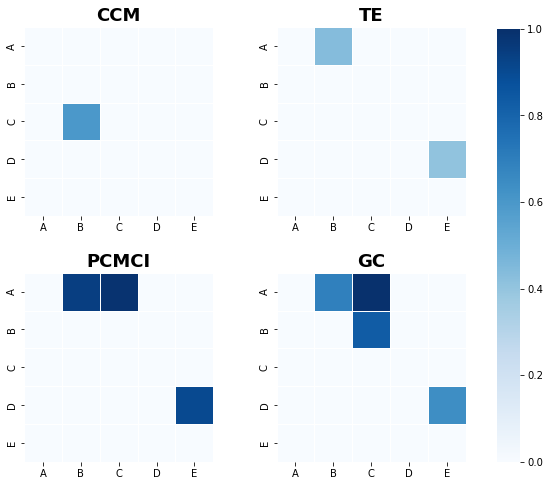

In [18]:
f, axes = plt.subplots(2, 2, figsize=(8,8))

f_1 = sns.heatmap(m_01, 
                  ax=axes[0][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_1.set_title('CCM', fontsize=18, fontweight='bold')

f_2 = sns.heatmap(m_02, 
                  ax=axes[0][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_2.set_title('TE', fontsize=18, fontweight='bold')

f_3 = sns.heatmap(m_03, 
                  ax=axes[1][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_3.set_title('PCMCI', fontsize=18, fontweight='bold')

cbar_ax = f.add_axes([.95, .125, .04, 0.752])
f_4 = sns.heatmap(m_04, 
                  ax=axes[1][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar_ax=cbar_ax, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_4.set_title('GC', fontsize=18, fontweight='bold')

plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [19]:
score = ce.evaluation()
print('Normalized_score:')
print(score)

Normalized_score:
0.8500000000000001


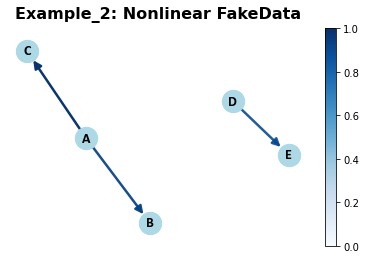

In [20]:
Graphic = causality_plotting(strength=strength_ensemble, 
                             feature_names=feature_names, 
                             title='Example_2: Nonlinear FakeData', 
                             name_size='short',
                             node_color="lightblue", 
                             title_size=16,
                             seed=0)
plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Example_2.jpg', 
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

Text(0.5, 1.0, 'Comprehensive Ensemble')

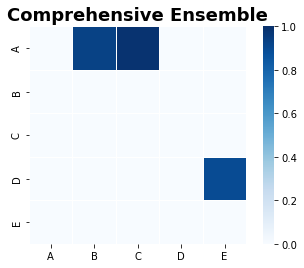

In [21]:
fig_0 = sns.heatmap(strength_ensemble, 
                    vmin=0, 
                    vmax=1, 
                    cmap='Blues', 
                    linewidths=.5, 
                    xticklabels=feature_names, 
                    yticklabels=feature_names, 
                    square=True)
fig_0.set_title('Comprehensive Ensemble', fontsize=18, fontweight='bold')